In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, auc, roc_auc_score, roc_curve, f1_score, classification_report, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder

import xgboost as xgb

import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import shakespeare

from keras.preprocessing.text import Tokenizer

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from IPython.display import display, HTML

import copy
import glob
import time
import os
import re
import gc
from tqdm import tqdm
import warnings

print(os.listdir("../input"))
stop_words = stopwords.words('english')
hamlet = ' '.join(shakespeare.words('hamlet.xml'))
macbeth = ' '.join(shakespeare.words('macbeth.xml'))
grids = {}
entropies = {}

string_size = 0.20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')
np.set_printoptions(precision=2)
pd.set_option('display.max_columns',8)
pd.set_option('precision',3)
%matplotlib inline

Using TensorFlow backend.


['glove6b300dtxt', 'glove6b50dtxt', 'spamham2', 'glove6b200d', 'glove6b100dtxt']


We are listing all the datasets we have and their location in `../input` directory.

In [2]:
%ls ../input/glove6b50dtxt
%ls ../input/glove6b100dtxt
%ls ../input/glove6b200d
%ls ../input/glove6b300dtxt
%ls ../input/spamham2/spam-ham/spam-ham

glove.6B.50d.txt
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
test_CSDMC2010_SPAM/  test_PU1/              train_ENRON/      train_trec07p/
test_ENRON/           test_trec07p/          train_Ling-Spam/
test_Ling-Spam/       train_CSDMC2010_SPAM/  train_PU1/


In [3]:
datasets = [ ('train_ENRON','test_ENRON'), ('train_PU1', 'test_PU1'), ('train_Ling-Spam', 'test_Ling-Spam'),\
            ('train_CSDMC2010_SPAM', 'test_CSDMC2010_SPAM'),('train_trec07p','test_trec07p')]

Below we are listing down number of spam and ham mails available for each dataset.

In [4]:
root_dir = '../input/spamham2/spam-ham/spam-ham'
for train_test in datasets:
    train_path = os.path.join(root_dir,train_test[0])
    test_path = os.path.join(root_dir,train_test[1])
    print(train_path,test_path)
    if len(train_test) == 2:
        if 'ENRON' in train_test[0]:
            print('Train Ham (%s) :'%train_test[0],len(glob.glob('%s/*/h/*'%train_path)))
            print('Train Spam (%s) :'%train_test[0],len(glob.glob('%s/*/s/*'%train_path)))
            print('Test Ham (%s) :'%train_test[1], len(glob.glob('%s/*/h/*'%test_path)))
            print('Test Spam (%s) :'%train_test[1], len(glob.glob('%s/*/s/*'%test_path)))
        else:
            print('Train Ham (%s) :'%train_test[0], len(glob.glob('%s/h/*'%train_path)))
            print('Train Spam (%s) :'%train_test[0], len(glob.glob('%s/s/*'%train_path)))
            print('Test Ham (%s) :'%train_test[1], len(glob.glob('%s/h/*'%test_path)))
            print('Test Spam (%s) :'%train_test[1], len(glob.glob('%s/s/*'%test_path)))

../input/spamham2/spam-ham/spam-ham/train_ENRON ../input/spamham2/spam-ham/spam-ham/test_ENRON
Train Ham (train_ENRON) : 11627
Train Spam (train_ENRON) : 11970
Test Ham (test_ENRON) : 4918
Test Spam (test_ENRON) : 5201
../input/spamham2/spam-ham/spam-ham/train_PU1 ../input/spamham2/spam-ham/spam-ham/test_PU1
Train Ham (train_PU1) : 424
Train Spam (train_PU1) : 342
Test Ham (test_PU1) : 194
Test Spam (test_PU1) : 139
../input/spamham2/spam-ham/spam-ham/train_Ling-Spam ../input/spamham2/spam-ham/spam-ham/test_Ling-Spam
Train Ham (train_Ling-Spam) : 1727
Train Spam (train_Ling-Spam) : 342
Test Ham (test_Ling-Spam) : 685
Test Spam (test_Ling-Spam) : 139
../input/spamham2/spam-ham/spam-ham/train_CSDMC2010_SPAM ../input/spamham2/spam-ham/spam-ham/test_CSDMC2010_SPAM
Train Ham (train_CSDMC2010_SPAM) : 2086
Train Spam (train_CSDMC2010_SPAM) : 966
Test Ham (test_CSDMC2010_SPAM) : 863
Test Spam (test_CSDMC2010_SPAM) : 412
../input/spamham2/spam-ham/spam-ham/train_trec07p ../input/spamham2/spam-h

### Gathering train and test file names
Below method takes as input train and test path where `spam` and `ham` mails are stored in folder named `s` and `h` respectively.

In [5]:
def gather_train_test_file_names(train_root, test_root):
    if 'ENRON' in train_root and 'ENRON' in test_root:
        train_spam_x = glob.glob('%s/*/s/*'%train_root)
        train_ham_x = glob.glob('%s/*/h/*'%train_root)
        
        test_spam_x = glob.glob('%s/*/s/*'%test_root)
        test_ham_x = glob.glob('%s/*/h/*'%test_root)
    else:
        train_spam_x = glob.glob('%s/s/*'%train_root)
        train_ham_x = glob.glob('%s/h/*'%train_root)

        test_spam_x = glob.glob('%s/s/*'%test_root)
        test_ham_x = glob.glob('%s/h/*'%test_root)
    
    train_x = train_spam_x + train_ham_x

    y_train_ham = np.zeros(len(train_ham_x))
    y_train_spam = np.ones(len(train_spam_x))
    y_train = np.concatenate((y_train_spam,y_train_ham))
    
    test_x = test_spam_x+test_ham_x

    y_test_spam = np.ones(len(test_spam_x))
    y_test_ham = np.zeros(len(test_ham_x))
    y_test = np.concatenate((y_test_spam,y_test_ham))
    
    del train_spam_x,train_ham_x, test_spam_x,test_ham_x, y_train_ham, y_train_spam, y_test_spam, y_test_ham

    gc.enable();gc.collect();
    
    return train_x, test_x, y_train, y_test

### Clean Data
Below method takes as input all list of file names and performs below mentioned steps
1. Loops through each file
2. Tokenize file contents ignoring unwanted characters using `ISO-8859-1` encoding
3. Remove stop words which are commonly occuring words in sentence and does not contribute much to classification.
4. Reconstruct text contents after all above steps properly cleans data.

In [6]:
def clean_data(x_total):
    x_all = np.empty_like(x_total)
    regex = re.compile(r'[a-z]+')
    for i, file_name in enumerate(x_total):
        with open(file_name, encoding='ISO-8859-1') as f:
            #print(file_name)
            #print(f.read())
            words = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in  word_tokenize(f.read().lower())] # .decode(errors='replace')
            words = [regex.match(word).string for word in words if regex.match(word)]
            words = [word for word in words if regex.match(word) if word not in stop_words]
            x_all[i] = ' '.join(words)
    
    print('Check whether lenth is same as original data : ',len(x_all) == len(x_total))

    return x_all

### Load Embeddings from Glove Dataset.
We are using glove embeddings ([Wikipedia Embeddings](https://nlp.stanford.edu/projects/glove/)) for our classification purpose. We are loading glove files and maintaining embeddings dictionary which keeps mapping from words to embedding vector of length 100.

In [7]:
def load_embeddings(embedding_file):
    embeddings_index = {}
    #f = open('pretrained_word_embeddings/glove.6B.300d.txt',encoding="utf8")
    f = open(embedding_file,encoding="utf8")
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

### Converting texts to Embedding vectors
Below method takes as input contents of mails. For each word in mail it tried to find embedding from embedding dictionary and then normalizes vectors of each words to create one vector which represents contents of that mail text.

In [8]:
def text2vec(s,size):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return list(np.zeros(size))
    return list(v / np.sqrt((v ** 2).sum()))

### Grid Search Params
Below method takes as input grid pipeline which consists of preprocessing steps & model, params of pipeline steps, train data, test data and then performs grid search on all params provided. After performing grid search it keeps track of best performing model and its params.

It also prints best train accuracy, test accuracy and params which gave good results.

In [9]:
def grid_search_through_params(model_name,pipeline, params,X, Y, X_test, Y_test):
    grid = GridSearchCV(pipeline, param_grid=params, scoring=['neg_log_loss', 'accuracy', 'roc_auc'], refit='accuracy', cv=3, n_jobs=-1, verbose=2)
    grid.fit(X, Y)

    #print('Train Accuracy : ',grid.score(X_train_subjects, Y_train_subjects))
    #print('Validation Accuracy : ',grid.score(X_test_subjects, Y_test_subjects))
    print('Best Score : ',grid.best_score_)
    print('Test Accuracy : ',grid.score(X_test, Y_test))
    print('Best Params : ',grid.best_params_)
    
    return grid

### Trying various models to find best performing one
Belo method takes as input train data, test data and types of preprocessing to be performed. It then tries various models like LogisticRegression, SVC, NaiveBayes and Extremem Gradient Boosting. It grid searches through each of models and tries to find best params. It also tries various preprocessing steps like Term Frequency-Inverse Document Frequency, Count Vectorizer and Embedding preprocessing steps with these models as preprocessing steps before performing actual parameter fitting.


In [10]:
def try_various_models_on_data(dataset_name, train_x_cleaned, y_train, test_x_cleaned, y_test, preprocessing='tfidfvectorizer'):
    params_lr = {
             'logisticregression__C': [1.0, 10,100],'logisticregression__penalty': ['l1', 'l2'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_svc = {
             'svc__C': [1.0, 10], 'svc__gamma': [ 0.1, 1.0,'auto', 'scale'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_xgb = {
             'xgbclassifier__n_estimators': [100,200,500,1000], 'xgbclassifier__max_depth': [3,4,5,], #'xgbclassifier__learning_rate': [0.01, 0.1],
             #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_nb = {
            'multinomialnb__alpha' : [0.1,0.5,1.0,]
    }
    params_rf = {
             'randomforestclassifier__n_estimators': [100,200,500], 'randomforestclassifier__max_depth': [3,5,None], #'xgbclassifier__learning_rate': [0.01, 0.1],
             #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    if preprocessing == 'tfidfvectorizer':
        params_lr.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_svc.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_xgb.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_nb.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_rf.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        pipeline_lr = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(TfidfVectorizer(), SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
        pipeline_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=123))
    elif preprocessing == 'countvectorizer':
        params_lr.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_svc.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_xgb.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_nb.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_rf.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        pipeline_lr = make_pipeline(CountVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(CountVectorizer(), SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(CountVectorizer(), xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(CountVectorizer(), MultinomialNB())
        pipeline_rf = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state=123))
    elif preprocessing == 'Embedding':
        pipeline_lr = make_pipeline(LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(MultinomialNB())
        pipeline_rf = make_pipeline(RandomForestClassifier(random_state=123))
    grids['LogisticRegression_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('LogisticRegression', pipeline_lr, params_lr, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['SVC_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('SVC', pipeline_svc, params_svc, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['XGBoost_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('XGBoost', pipeline_xgb, params_xgb, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['RandomForest_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('RandomForest', pipeline_rf, params_rf, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    if preprocessing != 'Embedding':
        grids['NaiveBayes_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('NaiveBayes', pipeline_nb, params_nb, train_x_cleaned, y_train, test_x_cleaned, y_test)

### Simple Dense Neural Network
Below is simple dense neural network of only linear layers.

In [11]:
def get_dense_model(num_max):
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    print('compile done')
    return model

### CNN Version 1
CNN model with embedding of size 50 and Convolution layer of size (64,3).

In [12]:
def get_cnn_model_v1(max_len): # added embed   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        100, #!!!!!!!!!!!!!!!!!!!!!!!
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(128,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

### CNN Version 2
CNN with embedding of size 50 and Convolution of size (256,3)

In [13]:
def get_cnn_model_v2(max_len):    # added filter
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        100,
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, #!!!!!!!!!!!!!!!!!!!
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

### Adding Shakshpere Macbeth Strings to test data
Below method adds text from macbeth which is 20% length of original mail text data to test data. Below exercise is performed to check whether we are able to confuse classifier by adding good text to it.

In [14]:
def add_meaningfull_strings(test_x, proportion=0.2):
    return np.array([x+' '+macbeth[:int(len(x)*proportion)] for x in test_x])

def add_meaningfull_strings_scrambled(test_x, proportion=0.2):
    import random
    test_x_2 = np.empty_like(test_x, dtype=np.str)
    for i, x in enumerate(test_x):
        temp = macbeth[:int(len(x)*proportion)]
        split_words = temp.split(' ')
        random.shuffle(split_words)
        temp = ' '.join(split_words)
        test_x_2[i] = x+' '+temp
    return test_x_2

### Calculate Entropies
Below method takes as input best performing model and test data. It generates shannon entropies, relative entropies, log losses for each of test sample and returns it.

In [15]:
def calculate_entropies(model_name, model, test_x, y_test):
    if 'DNN' in model_name or 'CNN' in model_name:
        y_test_preds = np.hstack((1- model.predict_proba(test_x), model.predict_proba(test_x)))
    else:
        y_test_preds = model.predict_proba(test_x)
    #print(y_test_preds)
    one_hot = sklearn.preprocessing.OneHotEncoder()
    one_hot_encoded = one_hot.fit_transform(y_test.reshape(-1,1))
    y_test_one_hot_encoded = one_hot_encoded.toarray()

    shannon_entropies,relative_entropies,log_losses_unnormalized,log_losses_normalized = [],[],[],[]
    for y_true, y_pred in zip(y_test_one_hot_encoded,y_test_preds):
        #print(entropy(y_pred))
        shannon_entropies.append(entropy(y_pred))
        relative_entropies.append(entropy(y_true, y_pred))
        log_losses_unnormalized.append(log_loss(y_true,y_pred,normalize=False))
        log_losses_normalized.append(log_loss(y_true,y_pred))
        
    return np.clip(np.array(shannon_entropies),0.0,6.0), np.clip(np.array(relative_entropies),0.0,6.0), np.array(log_losses_unnormalized), np.array(log_losses_normalized), y_test_preds

### Dataframe creation function for Entropies and other details
Below method takes as input various entropies and other details related to prediction and creates dataframe from it which we'll use later for display purpose.

In [16]:
def create_summary_dataframe(model_name, model, shannon_entropies, relative_entropies, test_x, y_test, y_test_preds, log_losses_unnormalized, log_losses_normalized):
    #print(shannon_entropies.shape, relative_entropies.shape, test_x.shape, y_test.shape, y_test_preds.shape, log_losses_unnormalized.shape, log_losses_normalized.shape)
    return pd.DataFrame(data={'Shannon':shannon_entropies,'Relative':relative_entropies,
                                      'Y True':y_test, 'Y Pred': model.predict_classes(test_x).flatten() if ('CNN' in model_name) or ('DNN' in model_name) else model.predict(test_x),
                                      'Y Preds(0)': y_test_preds[:,0],'Y Preds(1)': y_test_preds[:,1],
                                     'Log Loss(Unnormalized)':log_losses_unnormalized,
                                     'Log Loss(Normalized)':log_losses_normalized})

### Plot Entropy Histogram
Below method takes as input entropies and test data. It then prints histogram represeting spam and ham mails entropies.

In [17]:
def draw_entropy_histogram(model_name, entropies, y_test, entropy_type, before_after='Before'):
    plt.figure(figsize=(18,6))
    plt.hist(entropies[y_test == 1.0],bins=50, rwidth=0.6, linewidth=1.2, color='red', label='Spam',edgecolor='black')
    plt.hist(entropies[y_test == 0.0],bins=50, rwidth=0.6, linewidth=1.2, color='green', label='Ham',edgecolor='black')
    plt.xlabel(entropy_type)
    plt.ylabel('Frequency')
    plt.title('%s : %s (%s adding Random Strings), Mean : %.3f'%(model_name, entropy_type, before_after,entropies.mean()))
    plt.legend(loc='best')

### Plot Confusion Matrix
Below method takes as input best performing model and test data as input. It then generates confusion matrix and plots it.

In [18]:
def draw_confusion_matrix(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        conf_mat = confusion_matrix(y_test, model.predict_classes(test_x).flatten())
    else:
        conf_mat = confusion_matrix(y_test, model.predict(test_x))
    
    plt.figure(figsize=(12,12))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Plot ROC AUC Curve

Below method takes as input best performing model and test data. It then generates ROC AUC curve based on True Positives and False Positives.

In [19]:
def draw_roc_auc_curve(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        y_preds = model.predict_classes(test_x).flatten()
        y_preds_proba = model.predict_proba(test_x).flatten()
    else:
        y_preds = model.predict(test_x)
        y_preds_proba = model.predict_proba(test_x)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_preds_proba)
    r_auc = roc_auc_score(y_test, y_preds_proba)
    acc = accuracy_score(y_test, y_preds)
 
    plt.figure(figsize=(12,12))
    plt.plot(fpr, tpr, label="acc:%.2f auc:%.2f" % (acc, r_auc), linewidth=3)
    plt.ylabel('True Positives')
    plt.xlabel('False Positives')
    plt.title('%s : ROC AUC Curve'%model_name)
    plt.legend(loc="best")
    plt.show()


### Plot Precision Recall Curve
Below method takes as input best performing model and test data. It then draws precision recall curve.

In [20]:
def draw_precision_recall_curve(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        y_preds = model.predict_classes(test_x).flatten()
        y_preds_proba = model.predict_proba(test_x).flatten()
    else:
        y_preds = model.predict(test_x)
        y_preds_proba = model.predict_proba(test_x)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_preds_proba)
    p_auc = auc(recall, precision)
    acc = accuracy_score(y_test, y_preds)
 
    plt.figure(figsize=(12,12))
    plt.plot(recall, precision, label="acc:%.2f auc:%.2f" % (acc, p_auc), linewidth=3)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="best")
    plt.title('%s : Precision Recall Curve'%model_name)
    plt.show()

### Visualising Entropies generated by various models
Below method takes as input test data and dataset name. It then loops through each model for that particular dataset and prints average of entropies, entropies for wrong predictions and plots entropies as well.

In [21]:
def visualise_entropies(dataset_name, test_x_cleaned, y_test,before_after='Before'):
    for model_name, model in grids.items():
        if dataset_name in model_name:
            print('*'*80)
            print(model_name)
            print('*'*80)
            shannon_entropies,relative_entropies,log_losses_unnormalized,log_losses_normalized,y_test_preds = calculate_entropies(model_name, model, test_x_cleaned, y_test)
            #print(shannon_entropies.shape,relative_entropies.shape,log_losses_unnormalized.shape,log_losses_normalized.shape,y_test_preds.shape)
            print('Mean Shannon Entropy : ',shannon_entropies.mean())
            print('Mean Relative Entropy : ', relative_entropies.mean())

            entropies = create_summary_dataframe(model_name, model, shannon_entropies, relative_entropies, test_x_cleaned, y_test, y_test_preds, log_losses_unnormalized, log_losses_normalized)
            print('Head 5 : ')
            print(entropies[entropies['Y True'] != entropies['Y Pred']][['Shannon','Relative','Y True','Y Pred', 'Y Preds(0)','Y Preds(1)']].head())
            print('Tail 5 : ')
            print(entropies[entropies['Y True'] != entropies['Y Pred']][['Shannon','Relative','Y True','Y Pred', 'Y Preds(0)','Y Preds(1)']].tail())
            draw_entropy_histogram(model_name, shannon_entropies, y_test,'Shannon Entropy',before_after)
            draw_entropy_histogram(model_name, relative_entropies, y_test,'Relative Entropy',before_after)
            #entropies[model_name+'_'+before_after] = copy.deepcopy(entropies)

### Calculate Various Evaluation Metrics
Below methods takes as input test data and then prints log loss, roc auc, accuracy and classification report(f1 score, precision, recall).

In [22]:
def calculate_evaluation_metrics_and_display_metrics(dataset_name, test_x_cleaned, y_test):
    for model_name, model in grids.items():
        if dataset_name in model_name:
            print('*'*80)
            print(model_name)
            print('*'*80)
            if 'CNN' in model_name or 'DNN' in model_name:
                y_preds = model.predict_classes(test_x_cleaned).flatten()
            else:
                y_preds = model.predict(test_x_cleaned)
            print('Log Loss : ',log_loss(y_test, y_preds))
            if 'CNN' in model_name or 'DNN' in model_name:
                print('ROC AUC : ',roc_auc_score(y_test, model.predict_proba(test_x_cleaned).flatten()))
            else:
                print('ROC AUC : ',roc_auc_score(y_test, model.predict_proba(test_x_cleaned)[:,1]))
            print('Accuracy : ',accuracy_score(y_test, y_preds))
            print('Classification Report : ')
            print(classification_report(y_test, y_preds))
            draw_confusion_matrix(model_name, model, test_x_cleaned, y_test)
            draw_roc_auc_curve(model_name, model, test_x_cleaned, y_test)
            draw_precision_recall_curve(model_name, model, test_x_cleaned, y_test)

In [23]:
def visualize_coefficients(classifier, feature_names, n_top_features=30):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(18, 6))
    colors = ["red" if c < 0 else "green" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2*n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2*n_top_features), feature_names[interesting_coefficients],rotation=70, ha="right")
    plt.tight_layout(pad=0, h_pad=0, w_pad=0);

### Loading Embeddings

In [24]:
embeddings_index = load_embeddings('../input/glove6b300dtxt/glove.6B.300d.txt')
embedding_size = 300

400000it [00:35, 11280.07it/s]

Found 400000 word vectors.


## ENRON Dataset

In [25]:
#text = open('../input/spam-ham/spam-ham/train_ENRON/enron6/s/5815.2005-07-18.BG.spam.txt', encoding='ISO-8859-1').read().lower()
#text = open('../input/spam-ham/spam-ham/train_ENRON/enron6/s/5665.2005-07-09.BG.spam.txt', encoding='ISO-8859-1').read().lower()
#regex = re.compile(r"[a-z0-9]+")
#regex.match(text).string

## Loading and Cleaning Data

In [26]:
%%time
dataset = 'ENRON'

enron_train_root = os.path.join(root_dir, 'train_ENRON')
enron_test_root = os.path.join(root_dir, 'test_ENRON')

train_x, test_x, y_train, y_test = gather_train_test_file_names(enron_train_root, enron_test_root)    

print('Train : ',len(train_x),len(y_train))
print('Test : ',len(test_x),len(y_test))

train_x_cleaned = clean_data(train_x)
test_x_cleaned = clean_data(test_x)

#train_x_cleaned[0], train_x_cleaned[0].split()
gc.enable(); gc.collect();

Train :  23597 23597
Test :  10119 10119
Check whether lenth is same as original data :  True
Check whether lenth is same as original data :  True
CPU times: user 3min 5s, sys: 4.11 s, total: 3min 9s
Wall time: 4min 34s


In [27]:
#%%time
#grids = {}
#entropies = {}
#try_various_models_on_data(dataset, train_x_cleaned,y_train, test_x_cleaned, y_test, preprocessing='countvectorizer')
#gc.enable(); gc.collect();

In [28]:
#visualise_entropies(dataset, test_x_cleaned, y_test,'Before')

In [29]:
#calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cleaned, y_test)

In [30]:
## Adding meaningful strings to test dataset to confuse classifier
#test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)

In [31]:
#visualise_entropies(dataset, test_x_with_random_strings, y_test, 'After')

In [32]:
#calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

In [33]:
#visualize_coefficients(grids['LogisticRegression_countvectorizer_'+dataset].best_estimator_.steps[1][1], grids['LogisticRegression_countvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

## Word Embeddings Approach

## Trying various models and keeping track of best performing params

In [34]:
%%time
grids = {}
entropies = {}
train_x_glove = np.array([text2vec(x,embedding_size) for x in train_x_cleaned])
test_x_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

try_various_models_on_data(dataset, train_x_glove,y_train, test_x_glove, y_test, preprocessing='Embedding')
gc.enable(); gc.collect();

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.2min finished


Best Score :  0.8784167478916811
Test Accuracy :  0.9207431564383832
Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 75.5min finished


Best Score :  0.9250328431580286
Test Accuracy :  0.9686727937543236
Best Params :  {'svc__C': 10, 'svc__gamma': 1.0}

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 83.5min finished


Best Score :  0.9173199983048692
Test Accuracy :  0.9502915307836742
Best Params :  {'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 1000}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 10.7min finished


Best Score :  0.8858753231342967
Test Accuracy :  0.9247949402114833
Best Params :  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 500}

CPU times: user 21min 55s, sys: 2.97 s, total: 21min 58s
Wall time: 3h 15min 50s


## Visualise Shannon and Relative entropies for various models

********************************************************************************
LogisticRegression_Embedding_ENRON
********************************************************************************
Mean Shannon Entropy :  0.1988326930534082
Mean Relative Entropy :  0.20766432864466042
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
11    0.028     5.429     1.0     0.0       0.996       0.004
12    0.506     1.590     1.0     0.0       0.796       0.204
46    0.273     2.558     1.0     0.0       0.923       0.077
52    0.373     2.095     1.0     0.0       0.877       0.123
71    0.445     1.811     1.0     0.0       0.836       0.164
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10054    0.684     0.840     0.0     1.0       0.432       0.568
10061    0.529     1.508     0.0     1.0       0.221       0.779
10062    0.693     0.726     0.0     1.0       0.484       0.516
10069    0.686     0.818     0.0     1.0       0.442       0.55

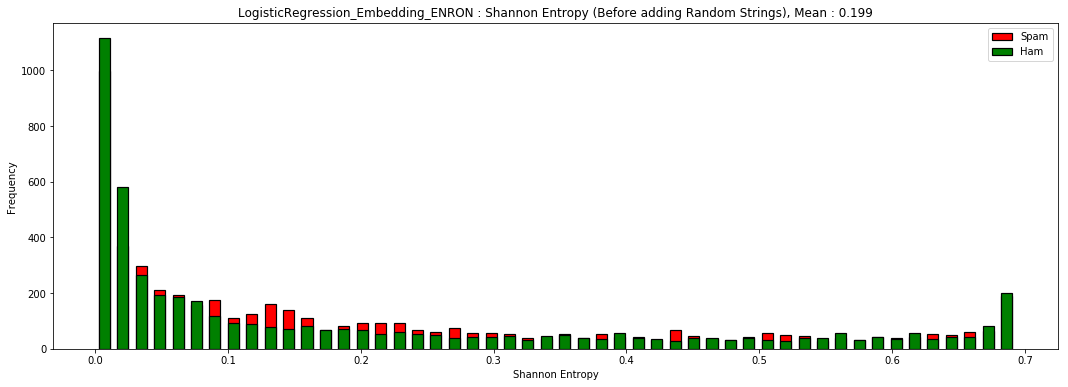

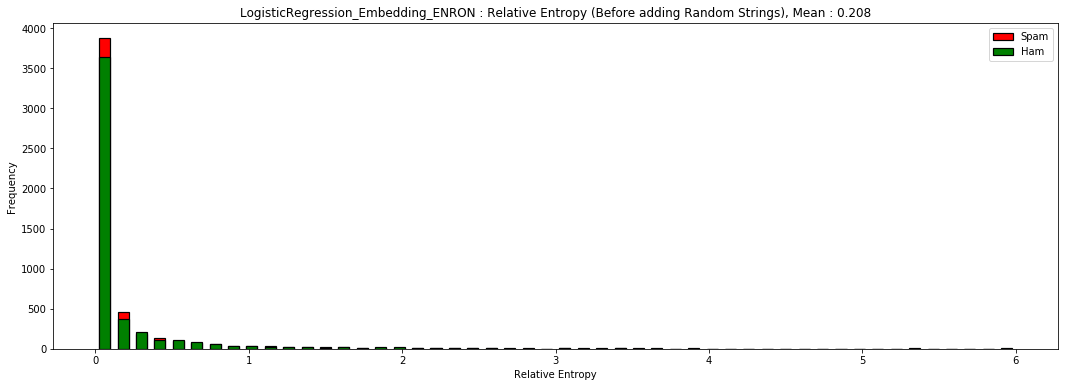

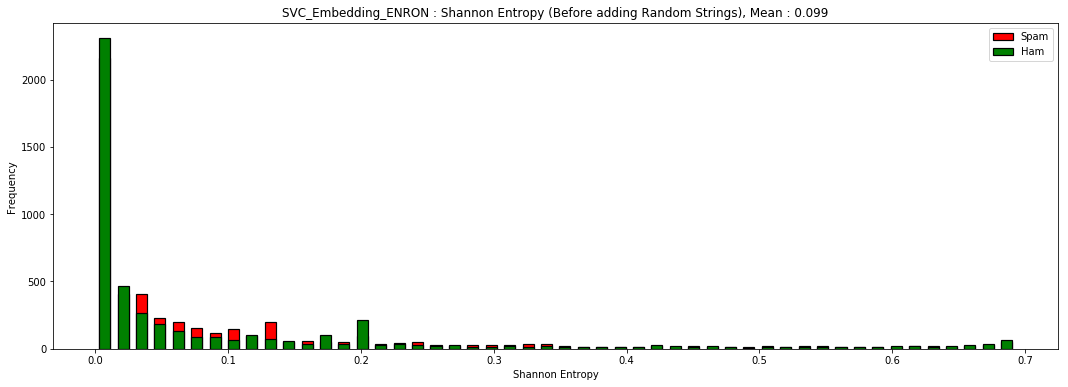

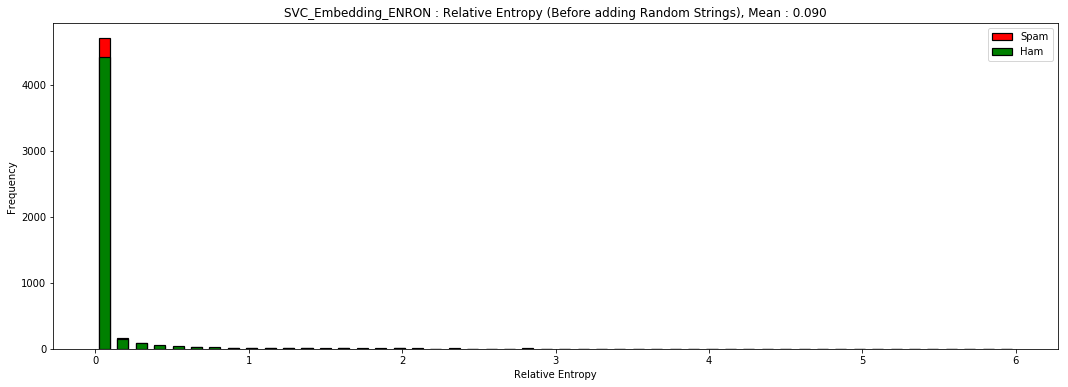

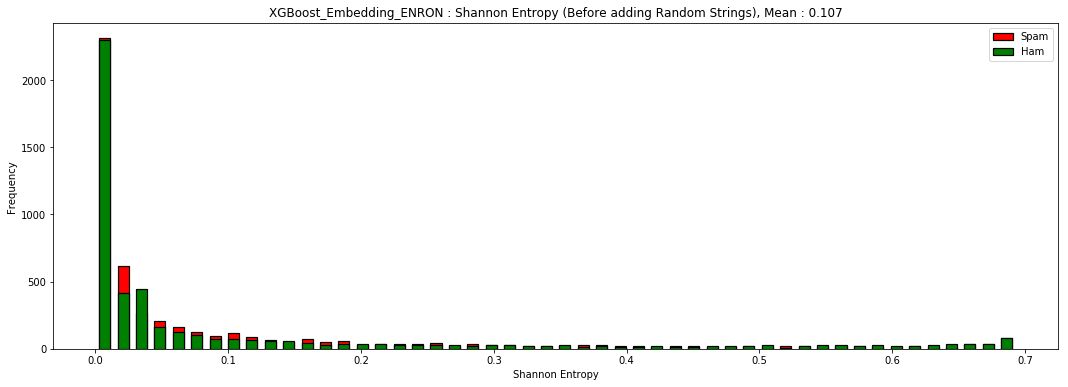

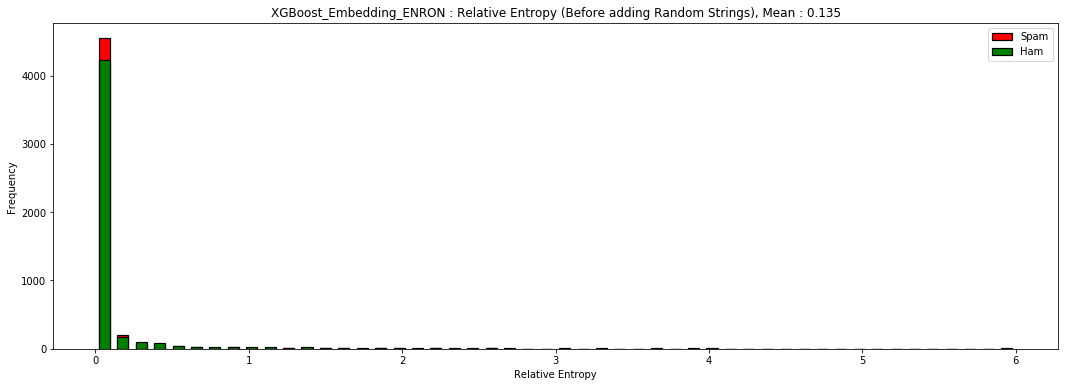

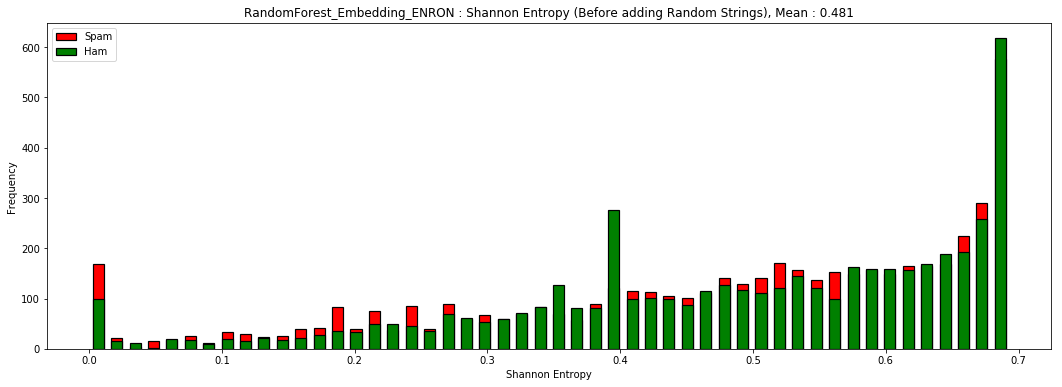

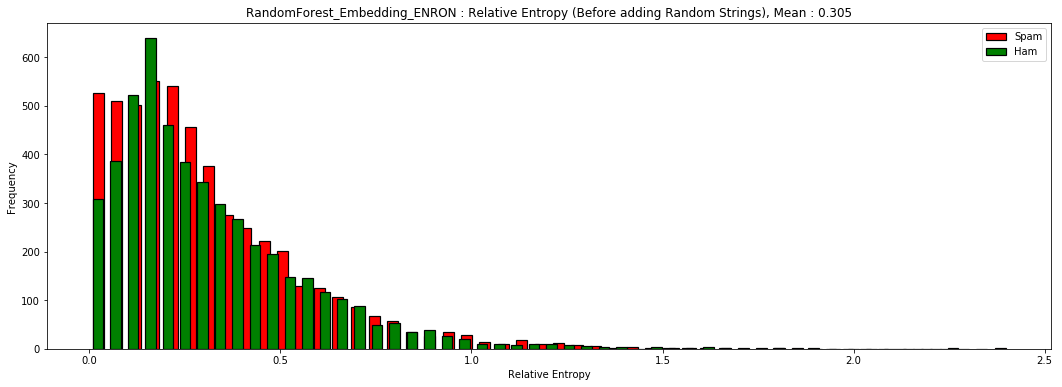

In [35]:
visualise_entropies(dataset, test_x_glove, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
LogisticRegression_Embedding_ENRON
********************************************************************************
Log Loss :  2.7374674276553215
ROC AUC :  0.9731157997504
Accuracy :  0.9207431564383832
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      4918
         1.0       0.92      0.93      0.92      5201

   micro avg       0.92      0.92      0.92     10119
   macro avg       0.92      0.92      0.92     10119
weighted avg       0.92      0.92      0.92     10119



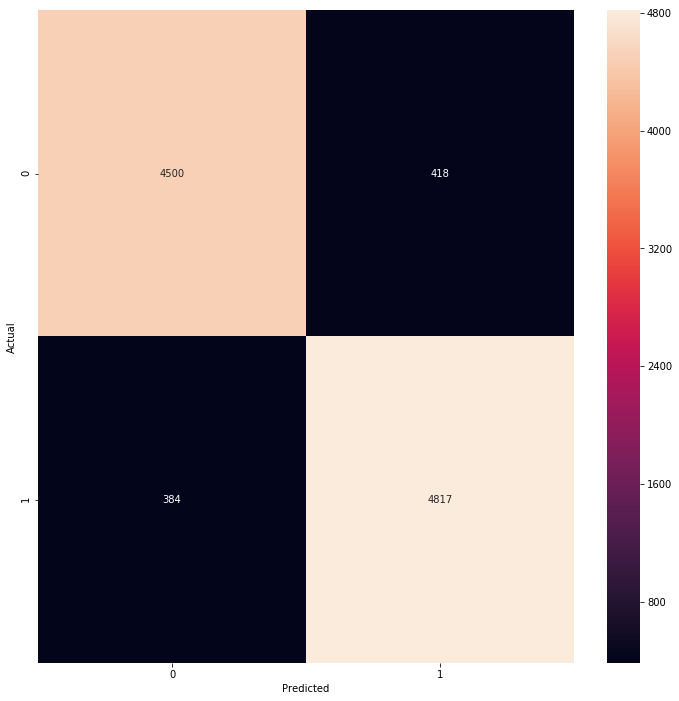

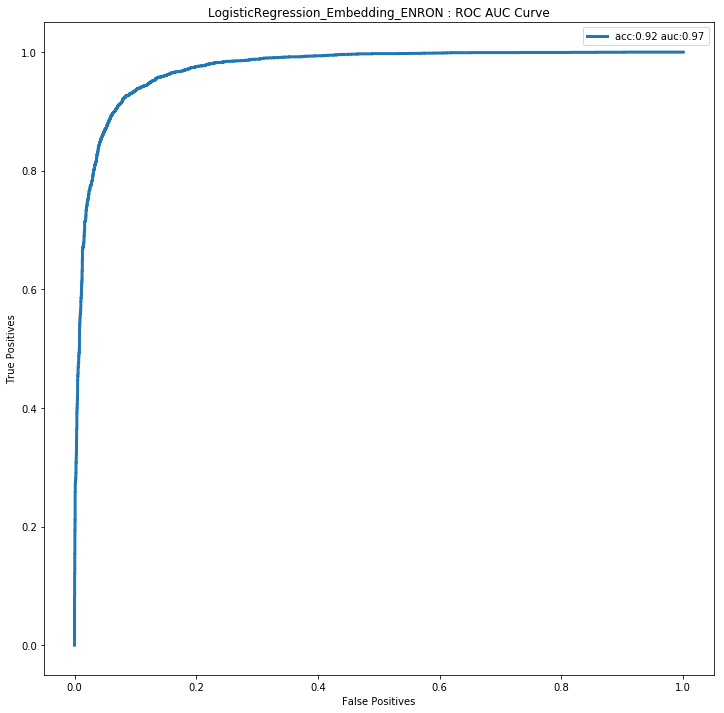

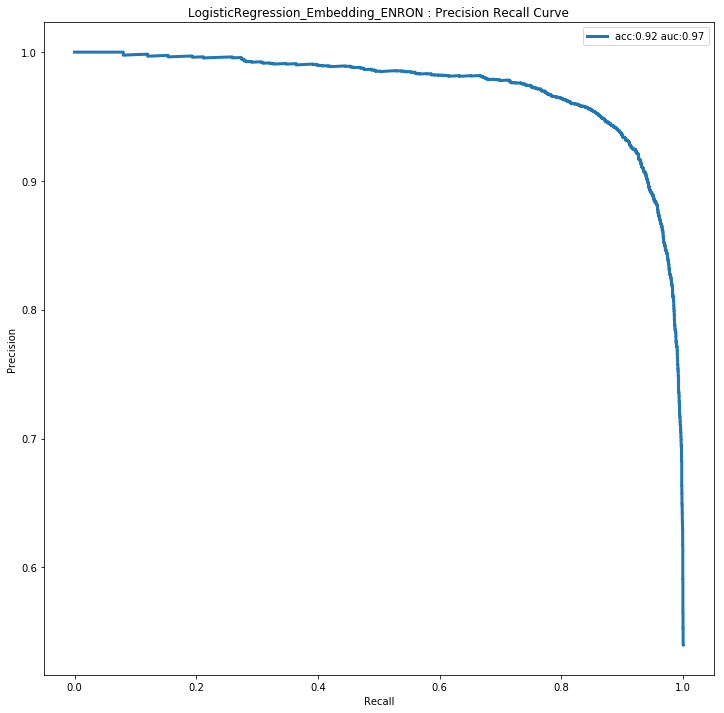

********************************************************************************
SVC_Embedding_ENRON
********************************************************************************
Log Loss :  1.0820163307802397
ROC AUC :  0.9943429482505594
Accuracy :  0.9686727937543236
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4918
         1.0       0.97      0.97      0.97      5201

   micro avg       0.97      0.97      0.97     10119
   macro avg       0.97      0.97      0.97     10119
weighted avg       0.97      0.97      0.97     10119



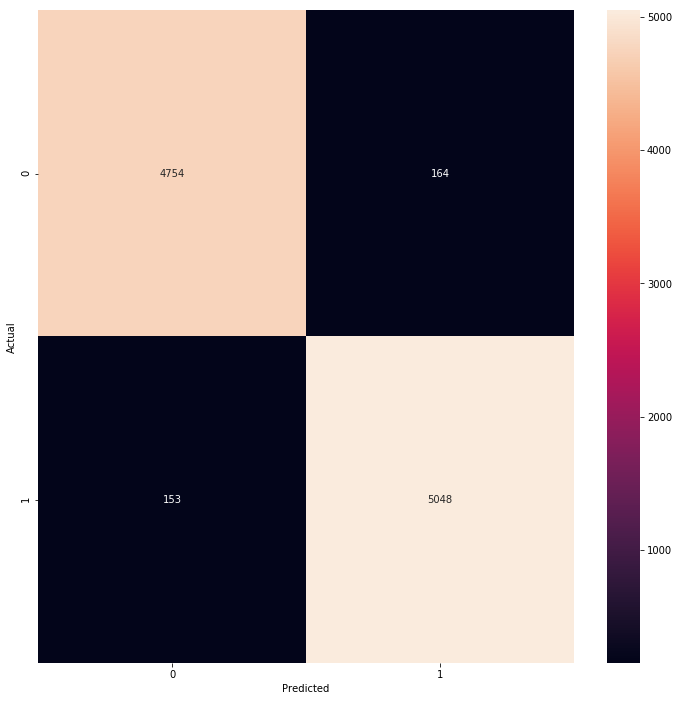

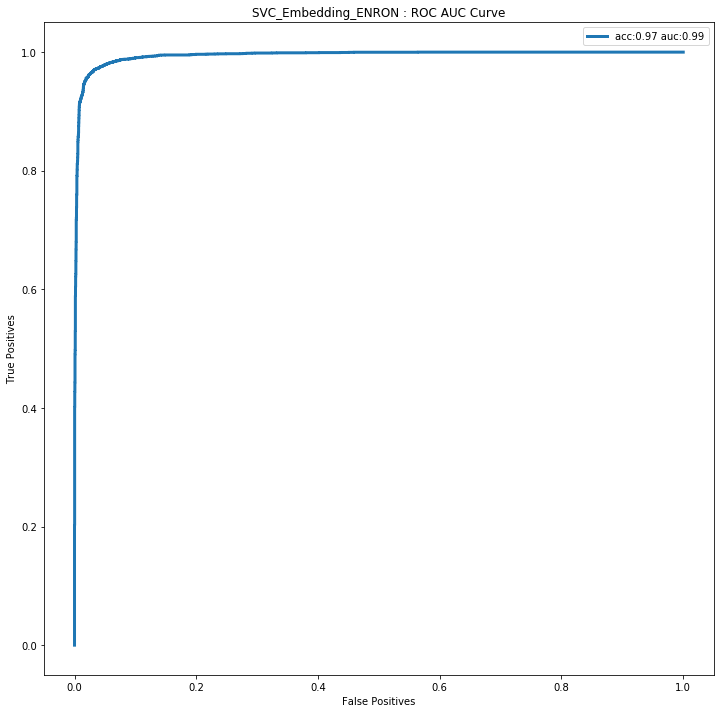

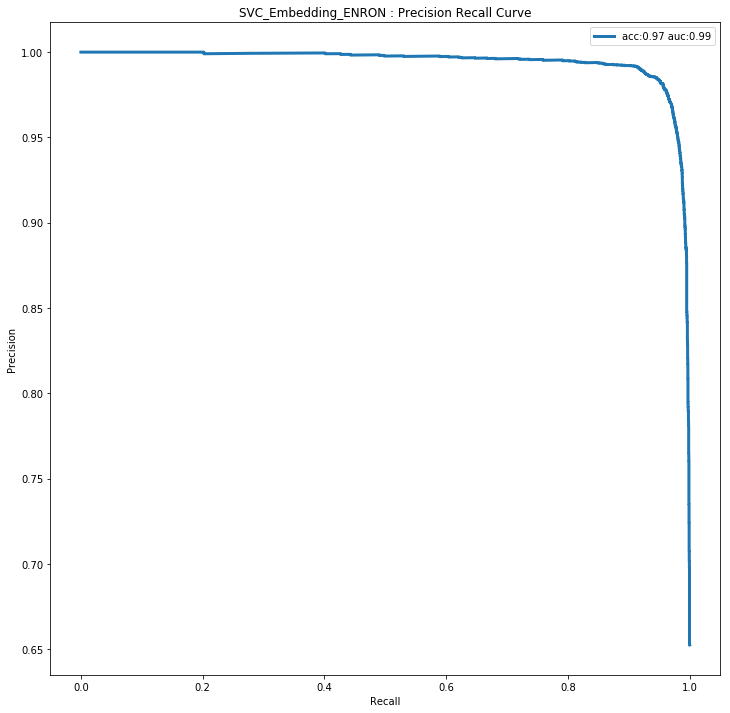

********************************************************************************
XGBoost_Embedding_ENRON
********************************************************************************
Log Loss :  1.7168908013789845
ROC AUC :  0.9886228944147586
Accuracy :  0.9502915307836742
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      4918
         1.0       0.95      0.95      0.95      5201

   micro avg       0.95      0.95      0.95     10119
   macro avg       0.95      0.95      0.95     10119
weighted avg       0.95      0.95      0.95     10119



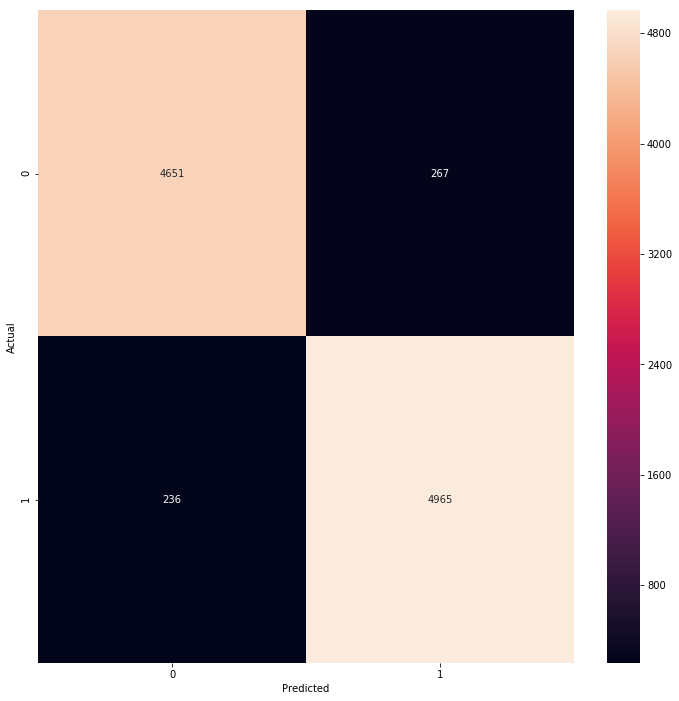

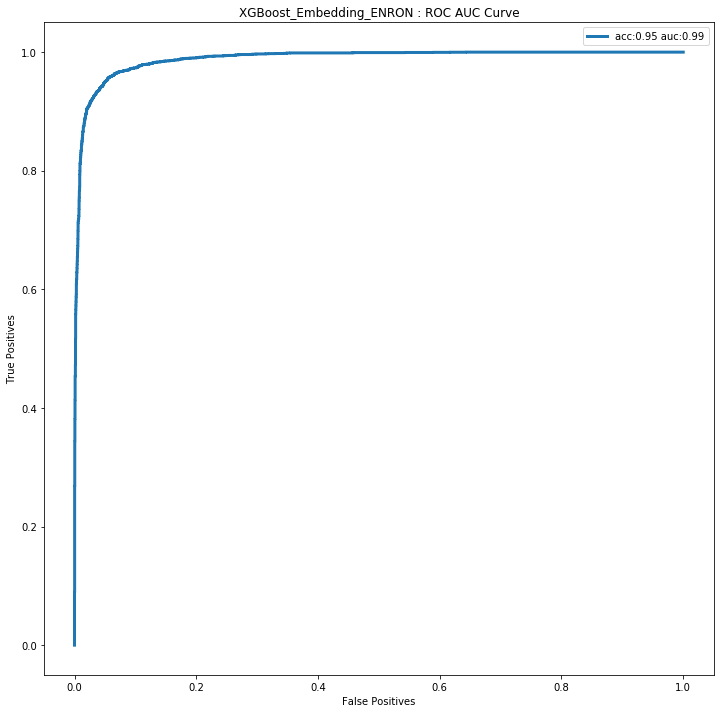

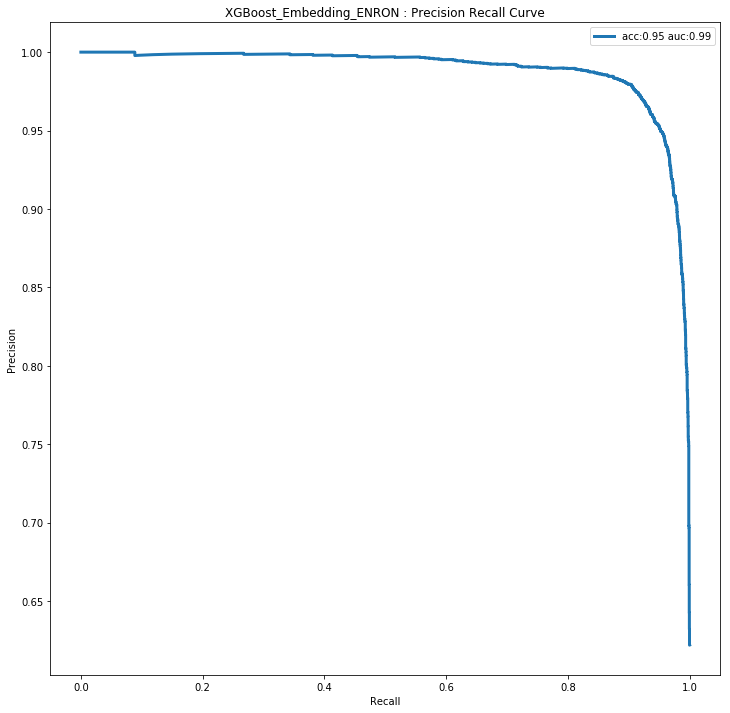

********************************************************************************
RandomForest_Embedding_ENRON
********************************************************************************
Log Loss :  2.597519190789792
ROC AUC :  0.9790684706596371
Accuracy :  0.9247949402114833
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      4918
         1.0       0.93      0.92      0.93      5201

   micro avg       0.92      0.92      0.92     10119
   macro avg       0.92      0.92      0.92     10119
weighted avg       0.92      0.92      0.92     10119



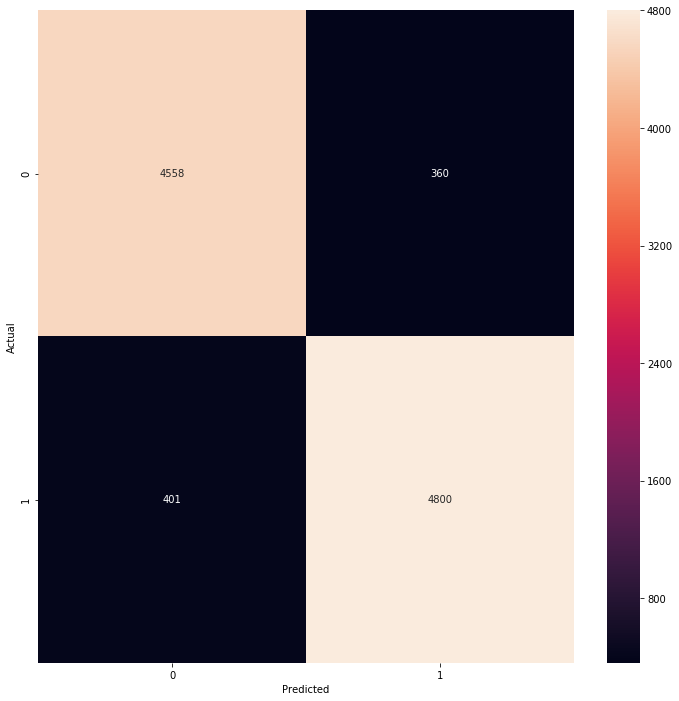

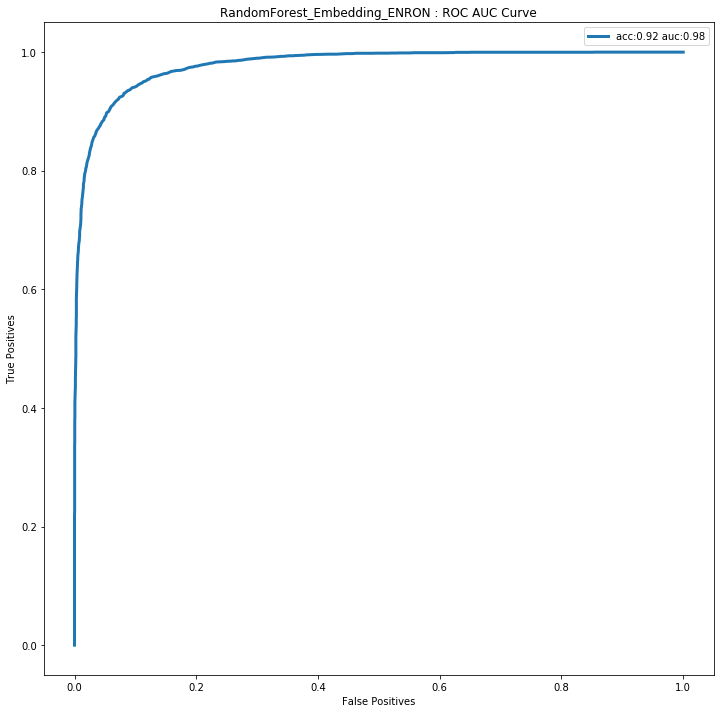

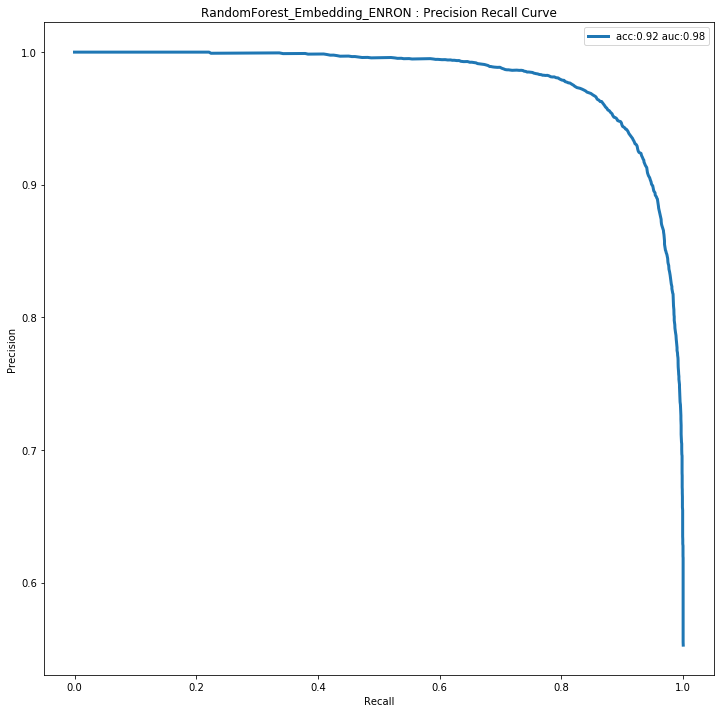

In [36]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_glove, y_test)

## Adding Meaningful Strings to Test Data

In [37]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
test_x_with_random_strings_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_ENRON
********************************************************************************
Mean Shannon Entropy :  0.1988326930534082
Mean Relative Entropy :  0.20766432864466042
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
11    0.028     5.429     1.0     0.0       0.996       0.004
12    0.506     1.590     1.0     0.0       0.796       0.204
46    0.273     2.558     1.0     0.0       0.923       0.077
52    0.373     2.095     1.0     0.0       0.877       0.123
71    0.445     1.811     1.0     0.0       0.836       0.164
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10054    0.684     0.840     0.0     1.0       0.432       0.568
10061    0.529     1.508     0.0     1.0       0.221       0.779
10062    0.693     0.726     0.0     1.0       0.484       0.516
10069    0.686     0.818     0.0     1.0       0.442       0.55

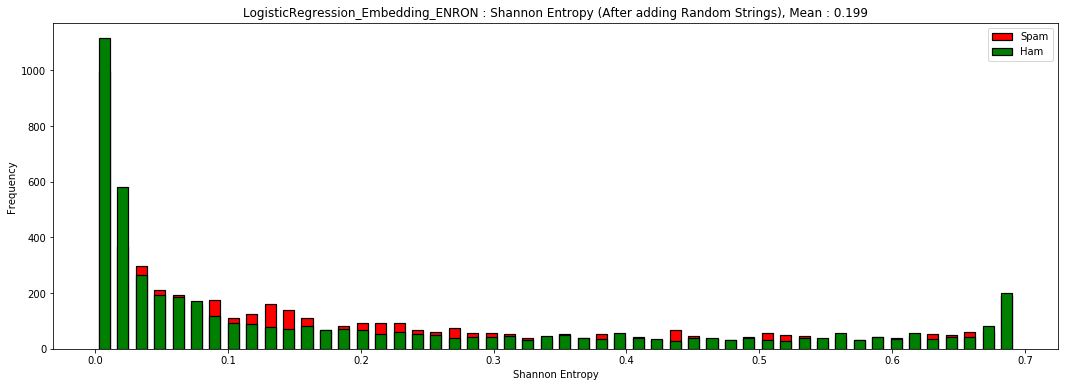

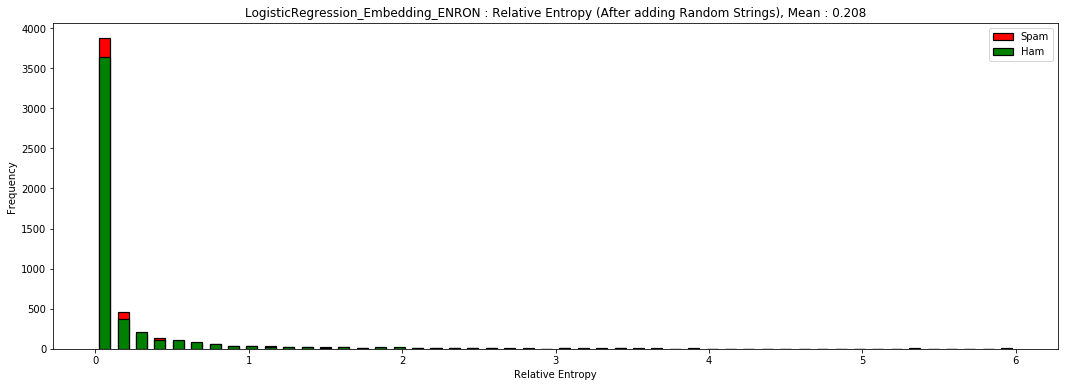

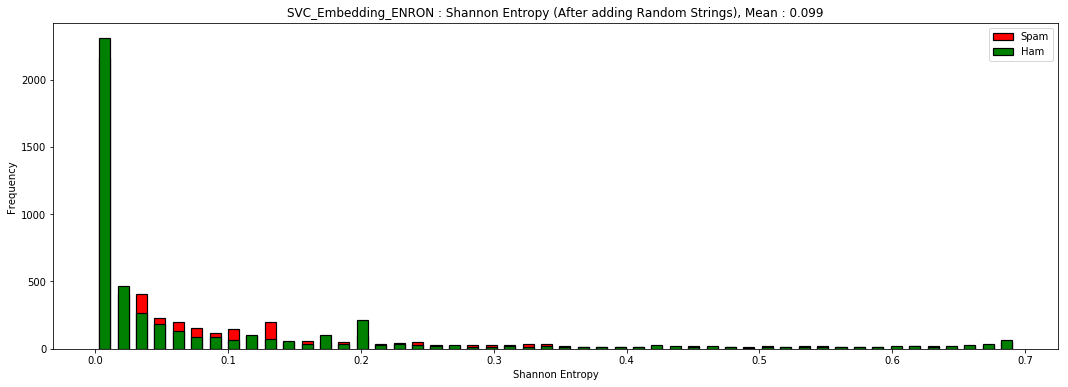

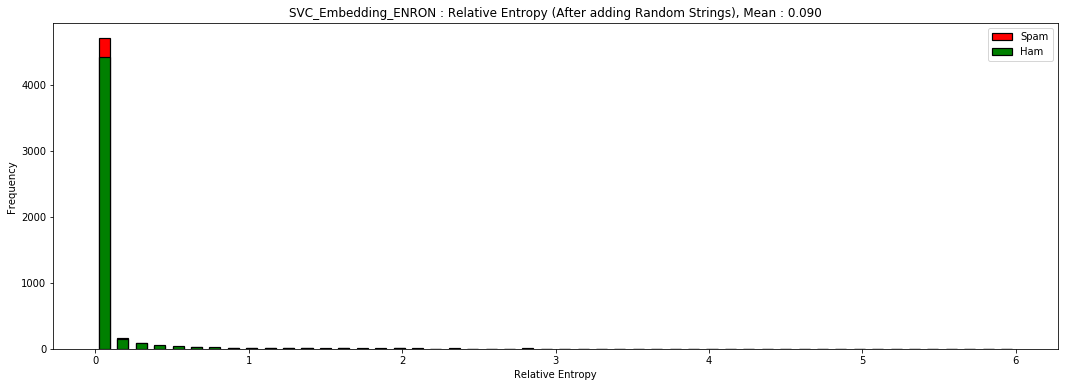

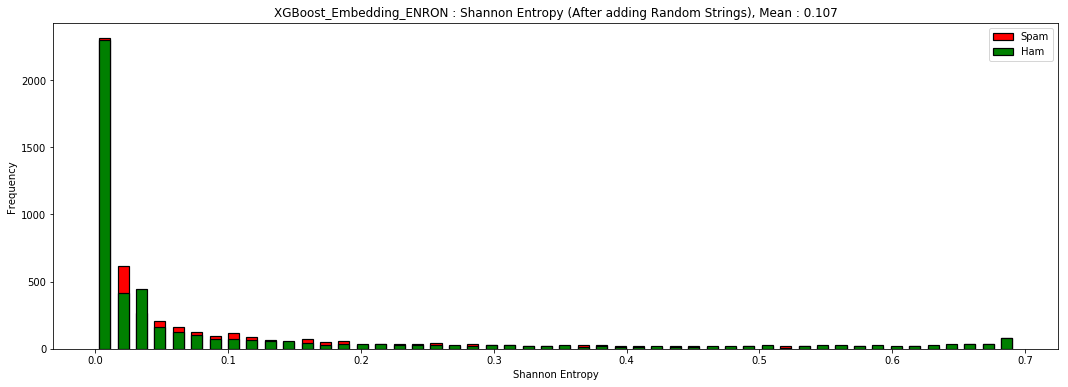

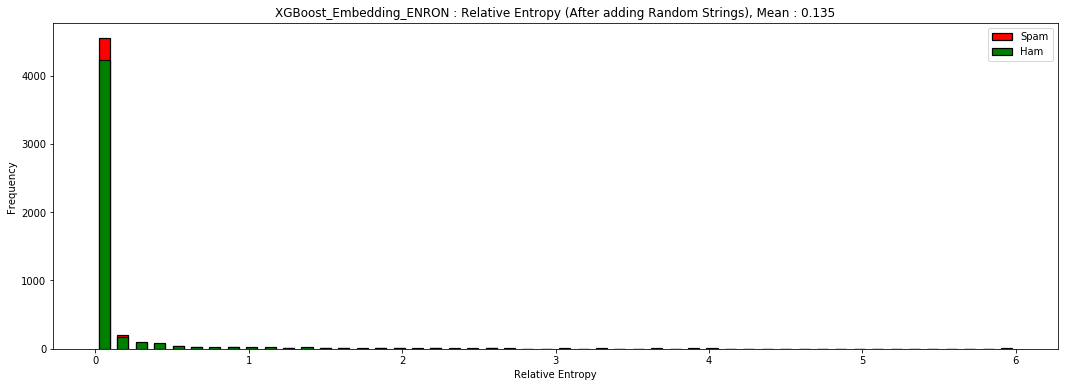

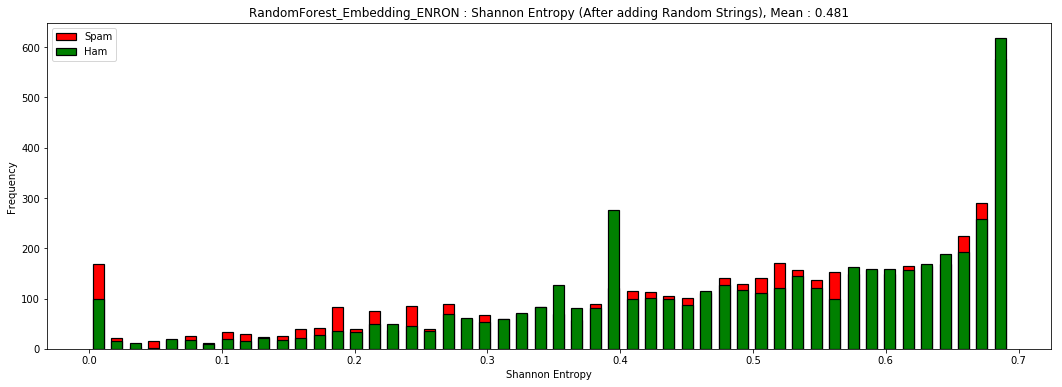

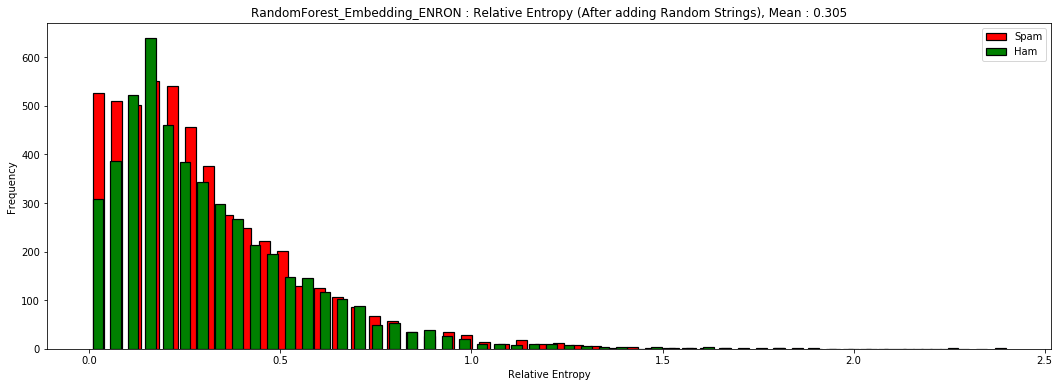

In [38]:
visualise_entropies(dataset, test_x_with_random_strings_glove, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_ENRON
********************************************************************************
Log Loss :  2.7374674276553215
ROC AUC :  0.9731157997504
Accuracy :  0.9207431564383832
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      4918
         1.0       0.92      0.93      0.92      5201

   micro avg       0.92      0.92      0.92     10119
   macro avg       0.92      0.92      0.92     10119
weighted avg       0.92      0.92      0.92     10119



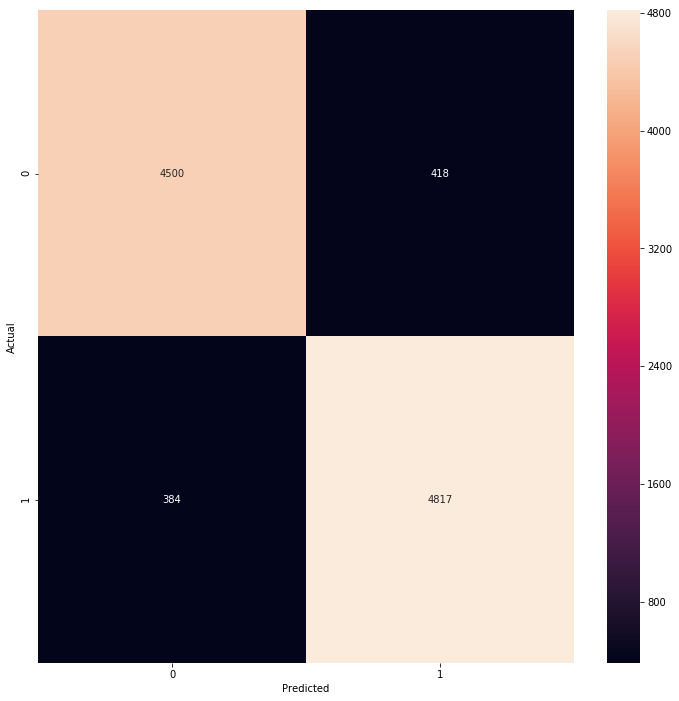

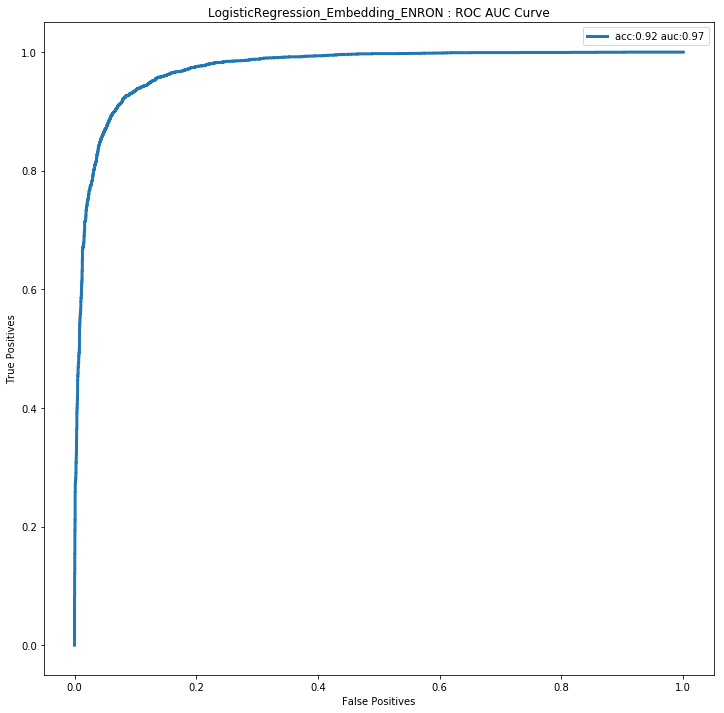

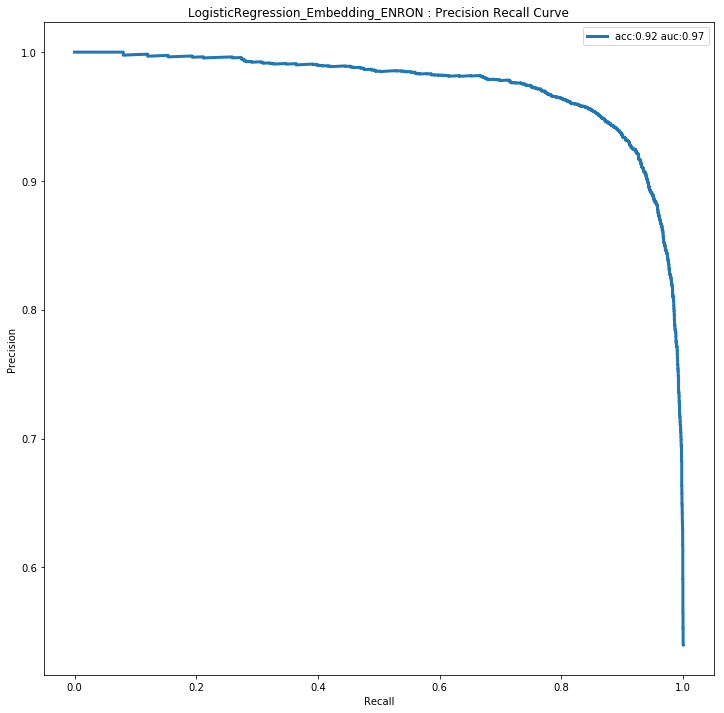

********************************************************************************
SVC_Embedding_ENRON
********************************************************************************
Log Loss :  1.0820163307802397
ROC AUC :  0.9943429482505594
Accuracy :  0.9686727937543236
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4918
         1.0       0.97      0.97      0.97      5201

   micro avg       0.97      0.97      0.97     10119
   macro avg       0.97      0.97      0.97     10119
weighted avg       0.97      0.97      0.97     10119



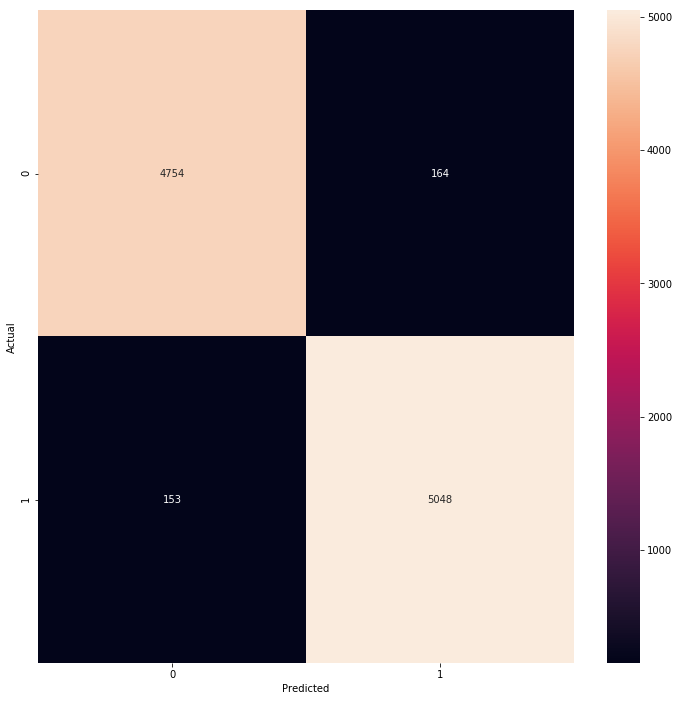

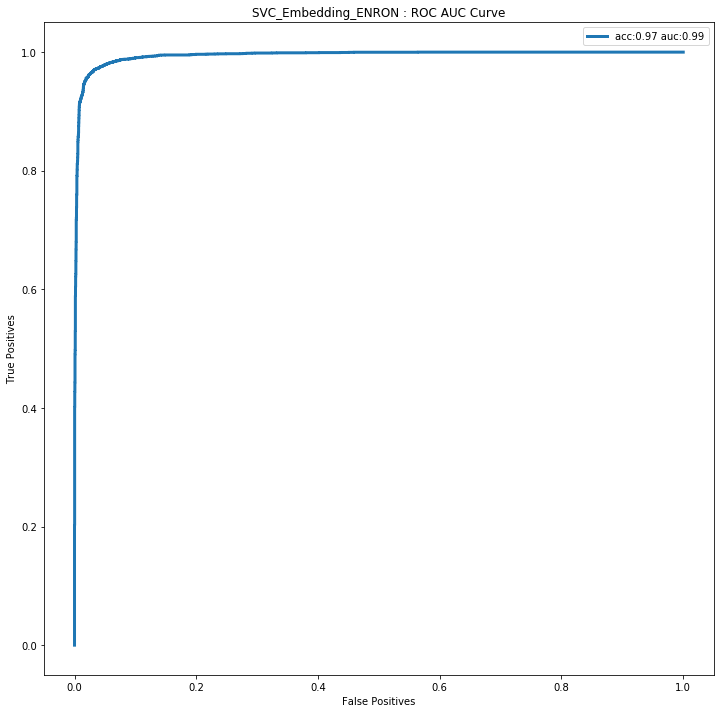

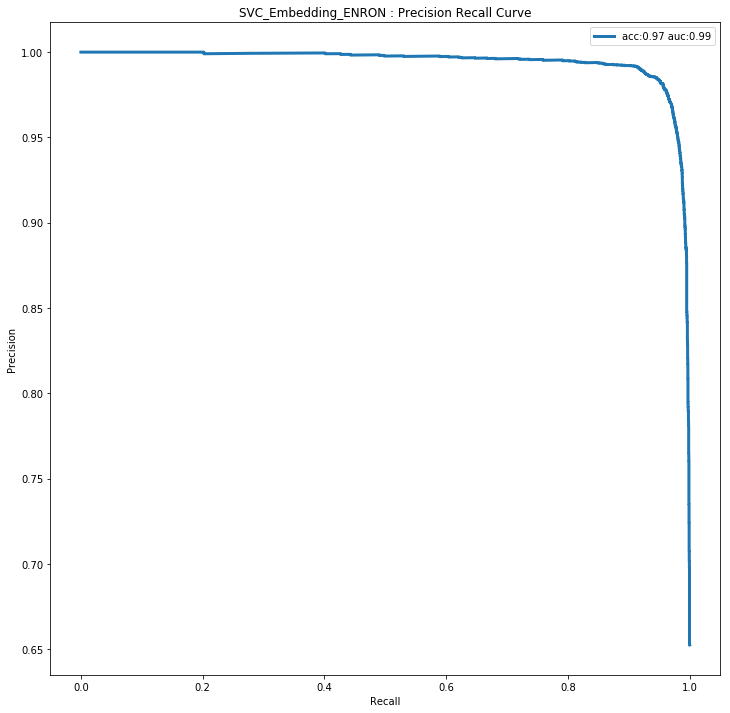

********************************************************************************
XGBoost_Embedding_ENRON
********************************************************************************
Log Loss :  1.7168908013789845
ROC AUC :  0.9886228944147586
Accuracy :  0.9502915307836742
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      4918
         1.0       0.95      0.95      0.95      5201

   micro avg       0.95      0.95      0.95     10119
   macro avg       0.95      0.95      0.95     10119
weighted avg       0.95      0.95      0.95     10119



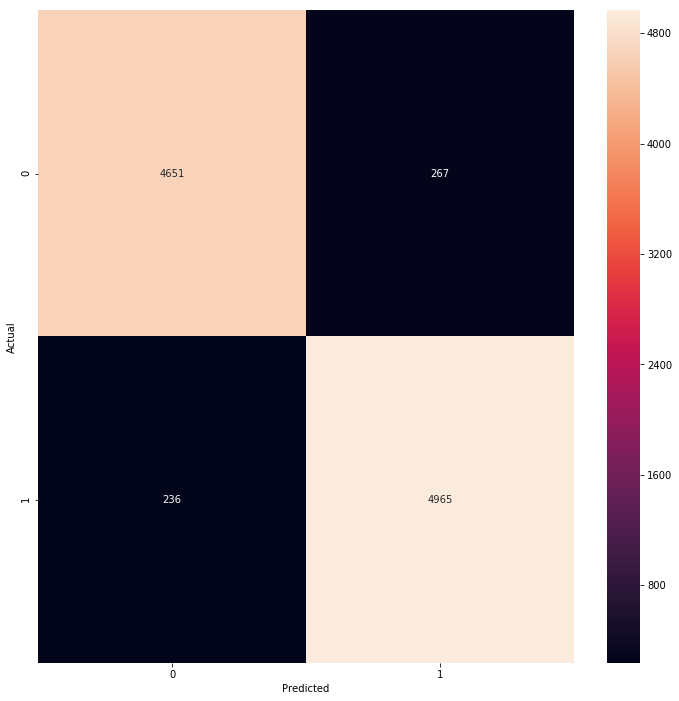

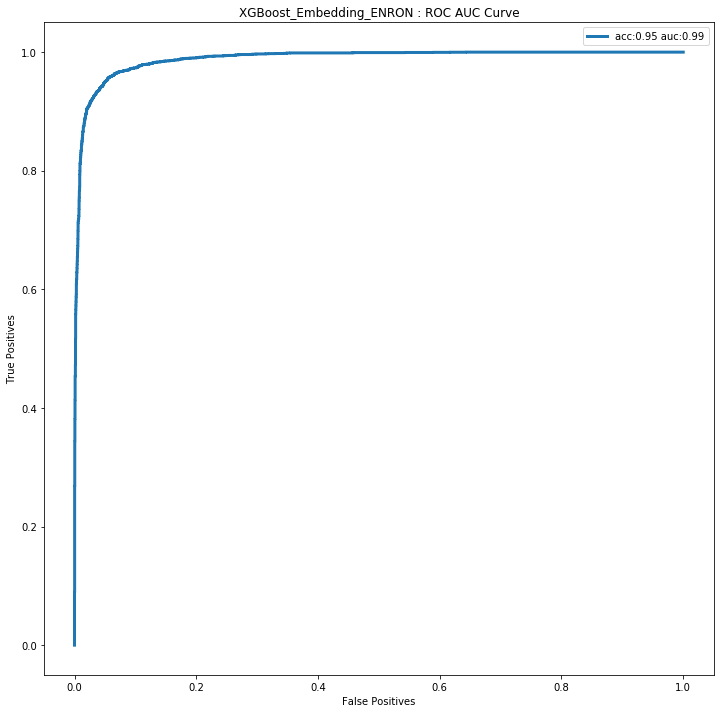

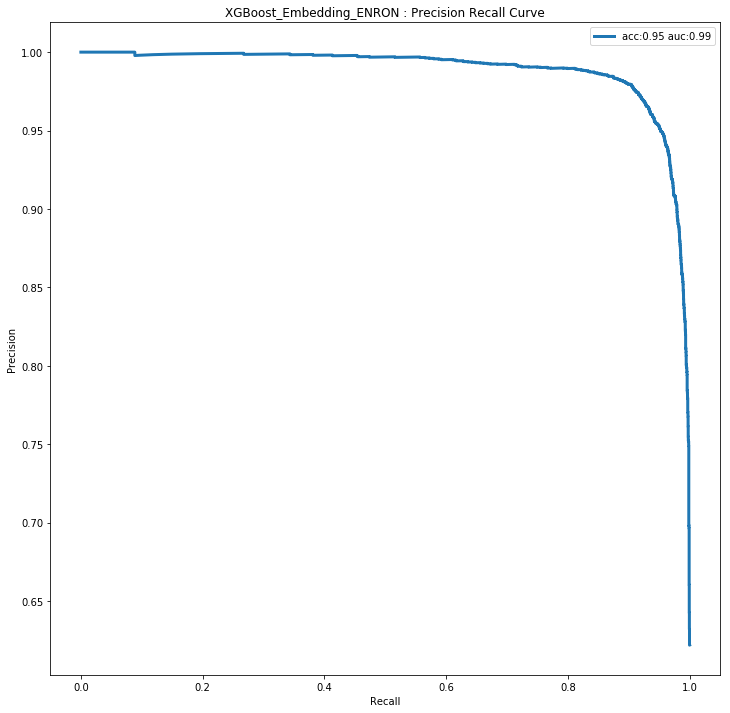

********************************************************************************
RandomForest_Embedding_ENRON
********************************************************************************
Log Loss :  2.597519190789792
ROC AUC :  0.9790684706596371
Accuracy :  0.9247949402114833
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      4918
         1.0       0.93      0.92      0.93      5201

   micro avg       0.92      0.92      0.92     10119
   macro avg       0.92      0.92      0.92     10119
weighted avg       0.92      0.92      0.92     10119



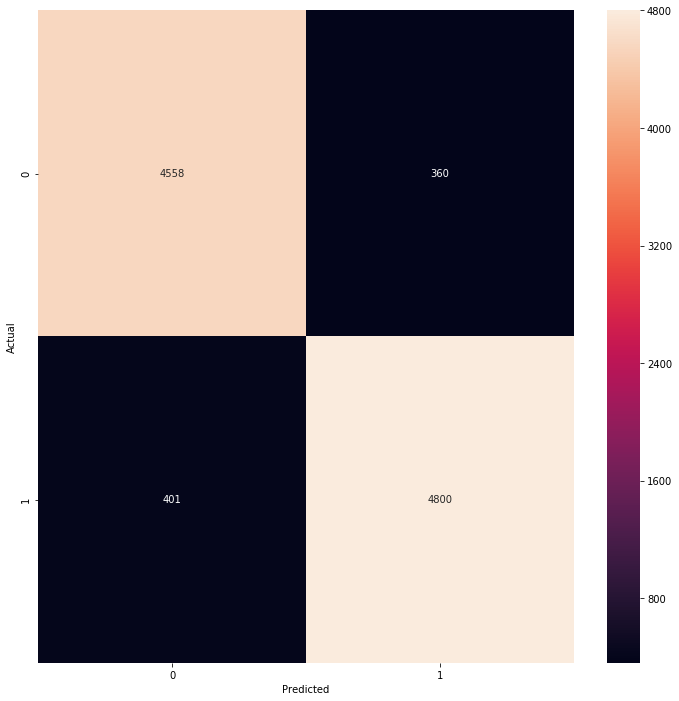

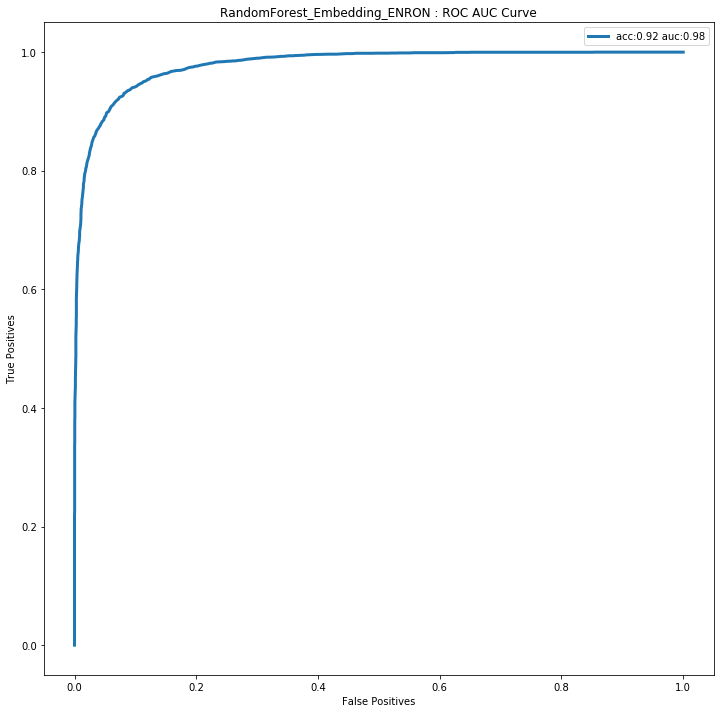

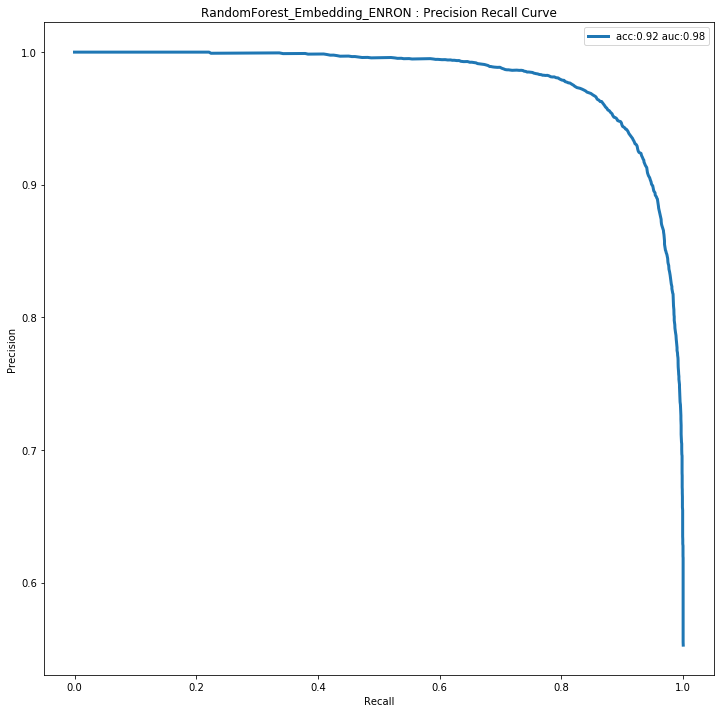

In [39]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_glove, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [40]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
test_x_with_random_strings_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_ENRON
********************************************************************************
Mean Shannon Entropy :  0.1988326930534082
Mean Relative Entropy :  0.20766432864466042
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
11    0.028     5.429     1.0     0.0       0.996       0.004
12    0.506     1.590     1.0     0.0       0.796       0.204
46    0.273     2.558     1.0     0.0       0.923       0.077
52    0.373     2.095     1.0     0.0       0.877       0.123
71    0.445     1.811     1.0     0.0       0.836       0.164
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10054    0.684     0.840     0.0     1.0       0.432       0.568
10061    0.529     1.508     0.0     1.0       0.221       0.779
10062    0.693     0.726     0.0     1.0       0.484       0.516
10069    0.686     0.818     0.0     1.0       0.442       0.55

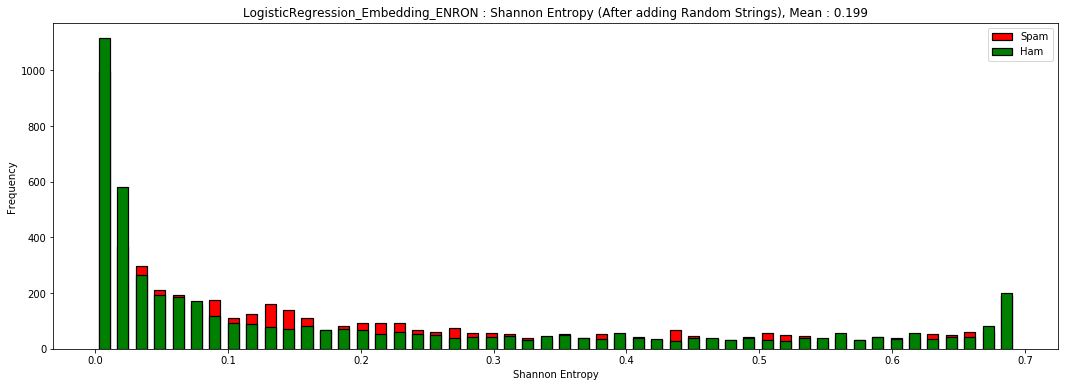

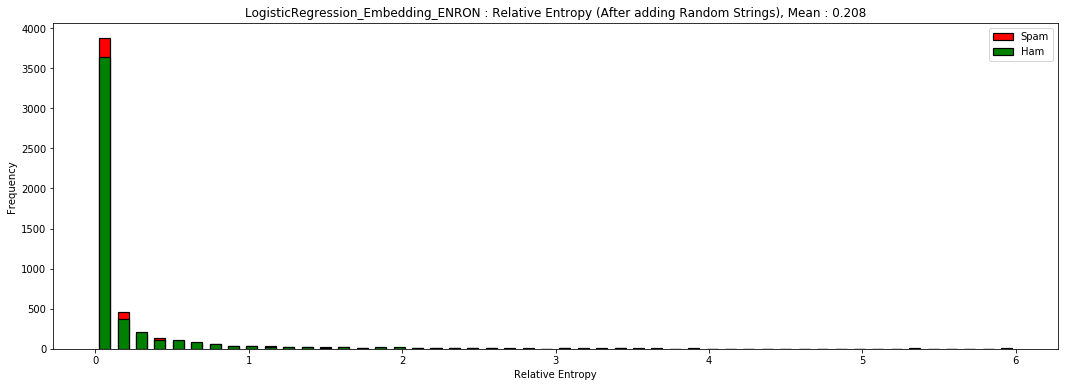

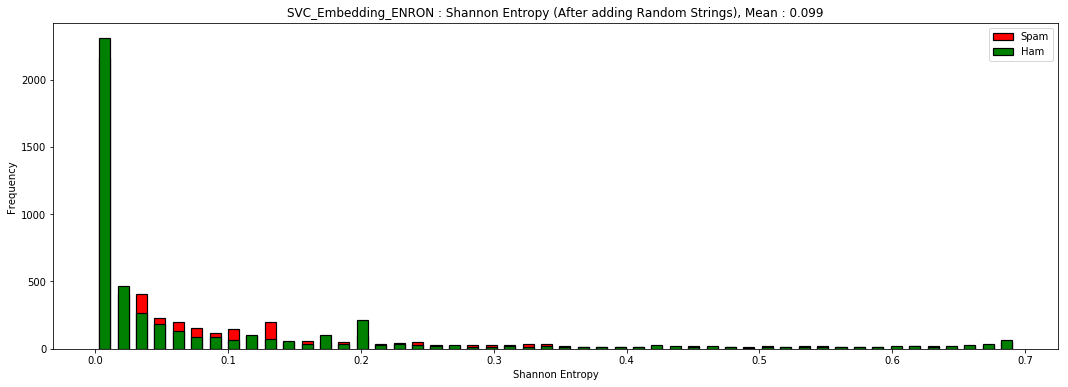

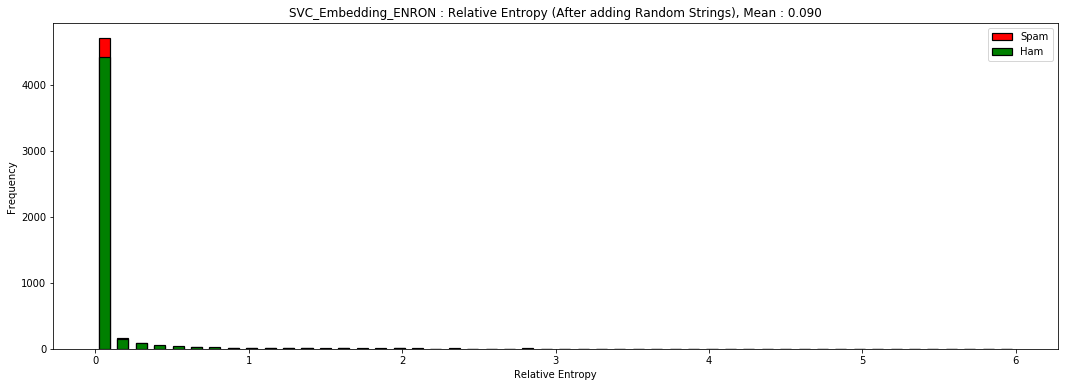

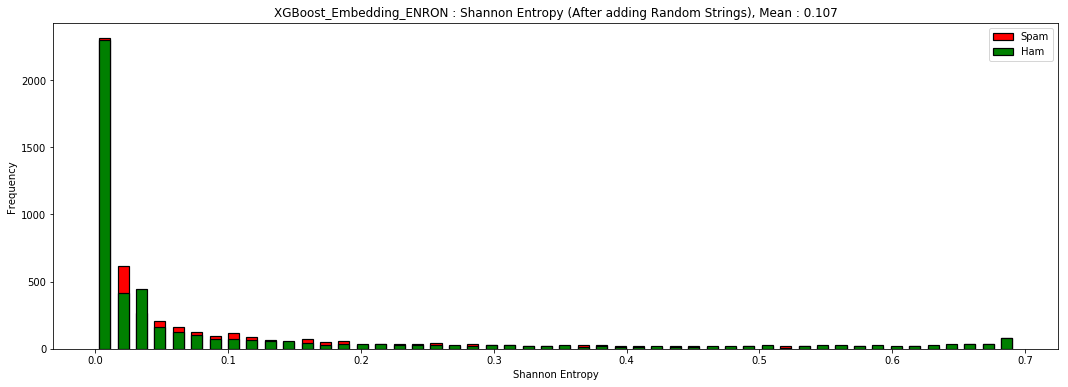

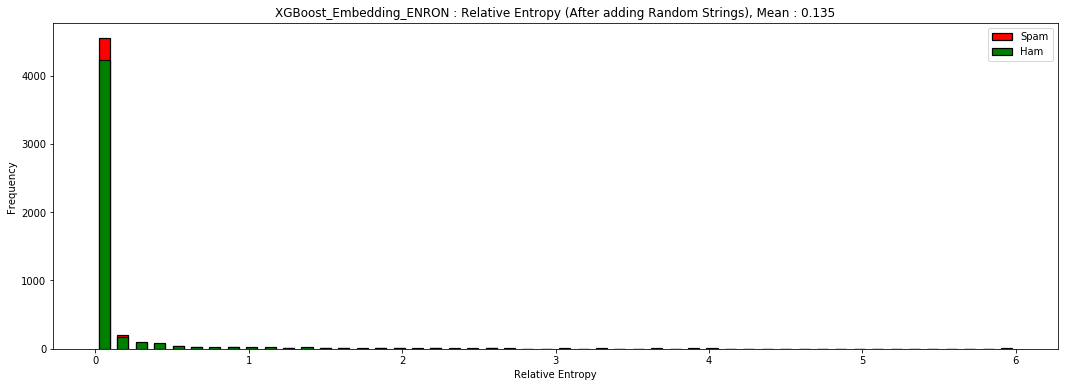

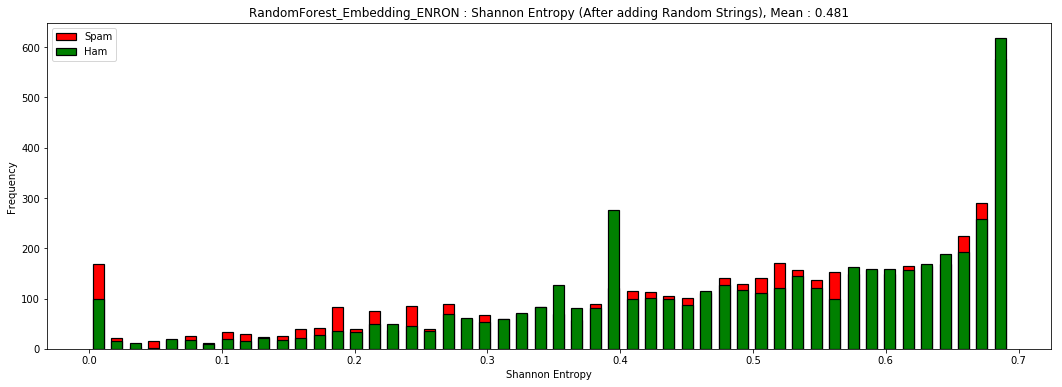

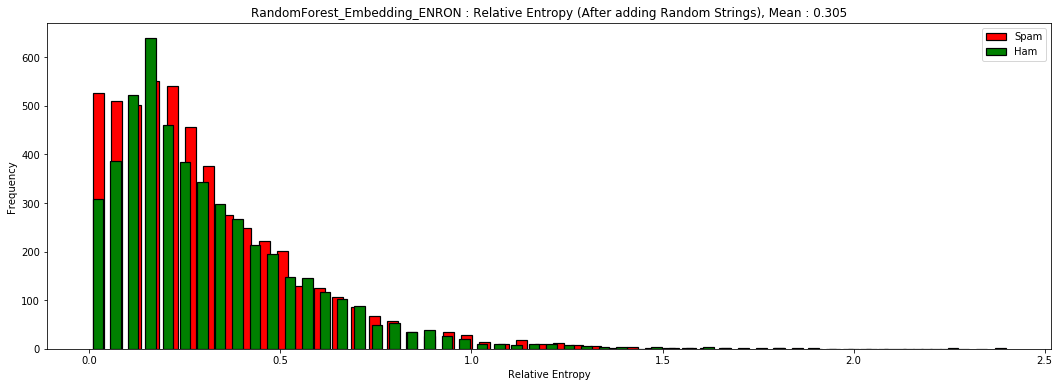

In [41]:
visualise_entropies(dataset, test_x_with_random_strings_glove, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_ENRON
********************************************************************************
Log Loss :  2.7374674276553215
ROC AUC :  0.9731157997504
Accuracy :  0.9207431564383832
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      4918
         1.0       0.92      0.93      0.92      5201

   micro avg       0.92      0.92      0.92     10119
   macro avg       0.92      0.92      0.92     10119
weighted avg       0.92      0.92      0.92     10119



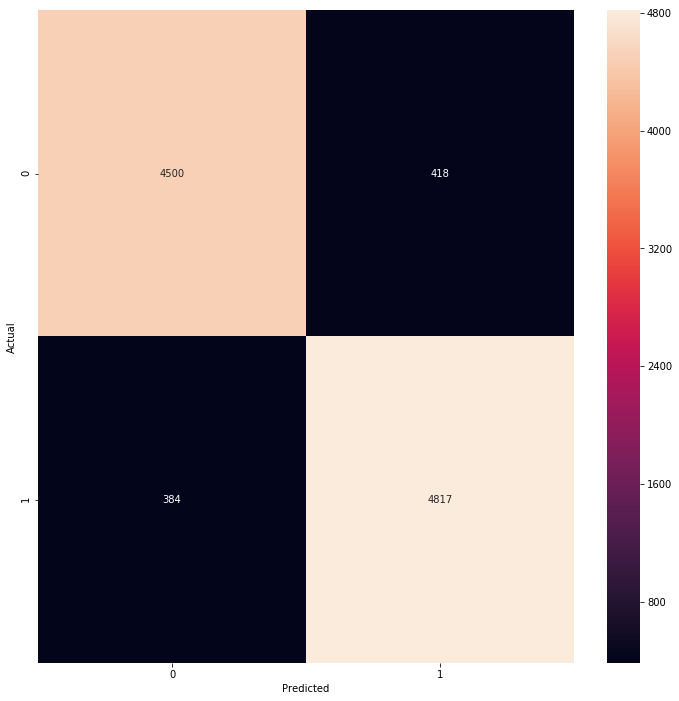

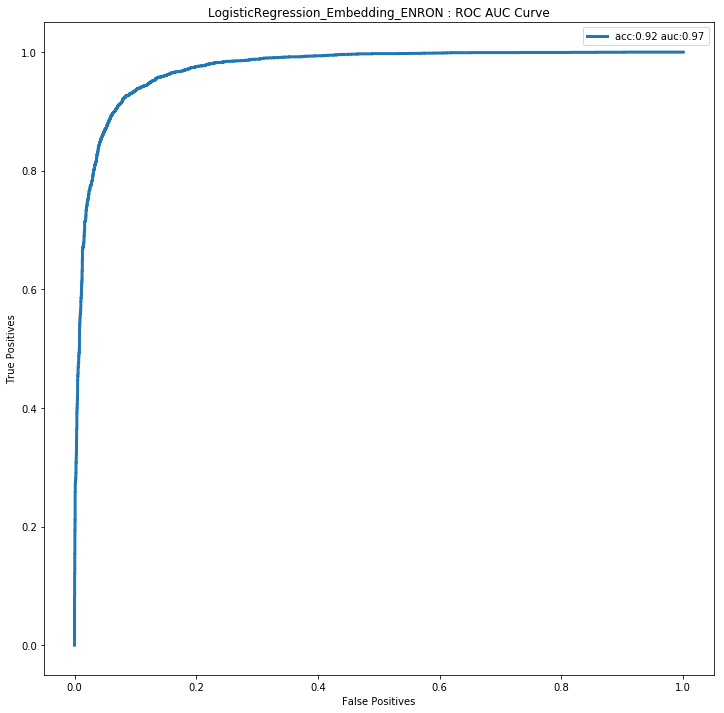

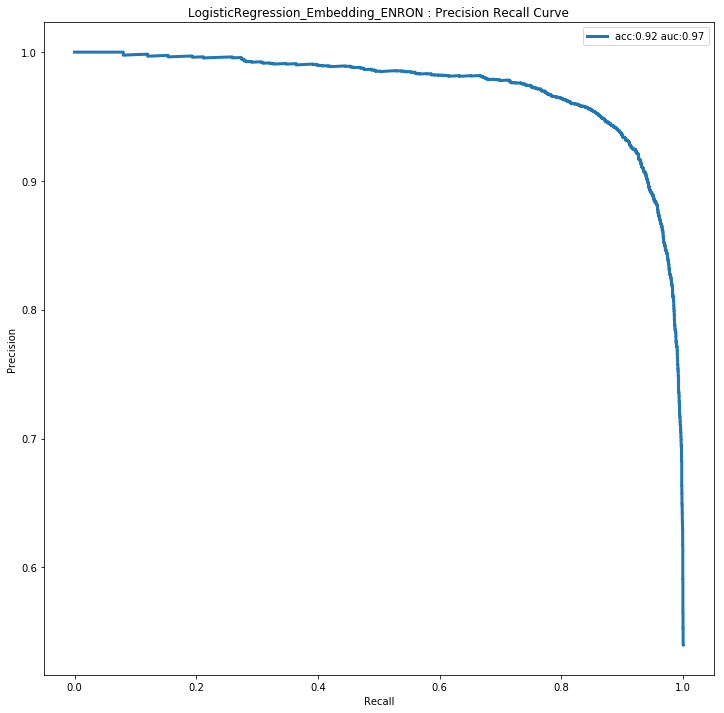

********************************************************************************
SVC_Embedding_ENRON
********************************************************************************
Log Loss :  1.0820163307802397
ROC AUC :  0.9943429482505594
Accuracy :  0.9686727937543236
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4918
         1.0       0.97      0.97      0.97      5201

   micro avg       0.97      0.97      0.97     10119
   macro avg       0.97      0.97      0.97     10119
weighted avg       0.97      0.97      0.97     10119



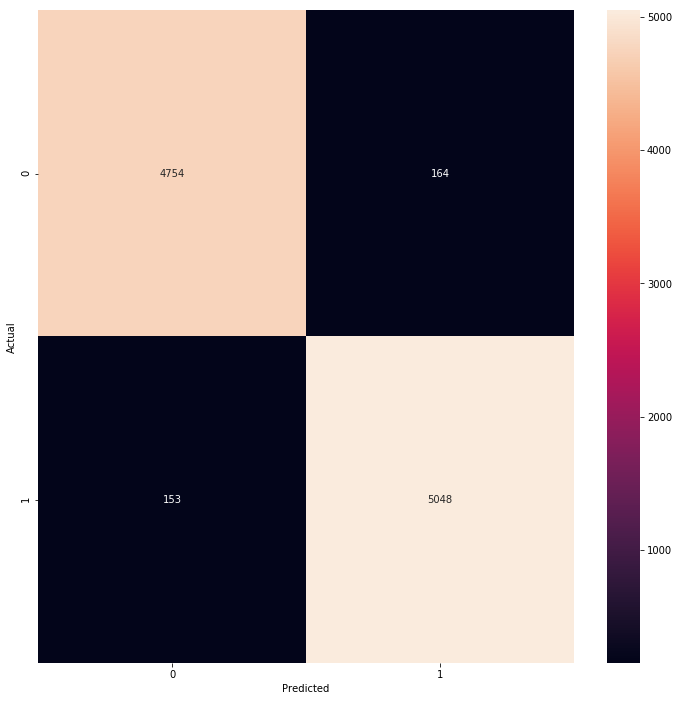

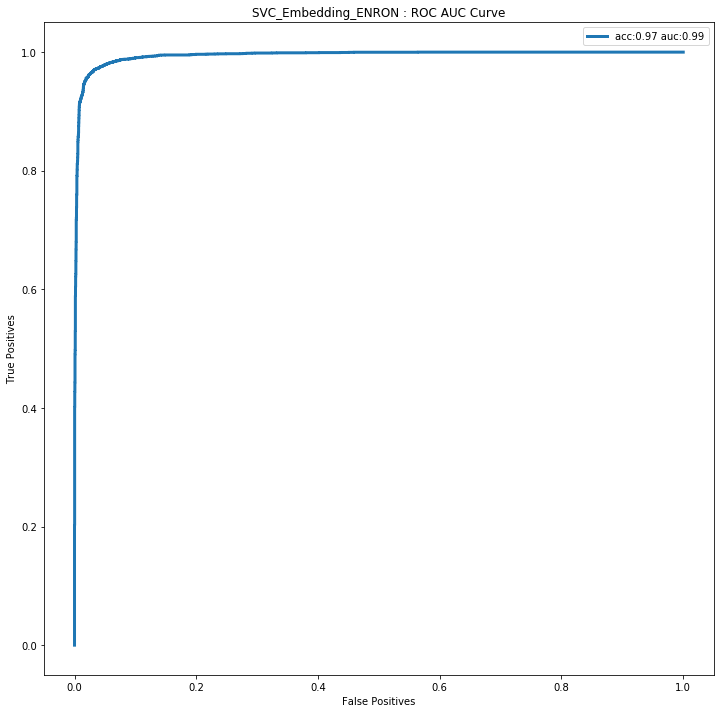

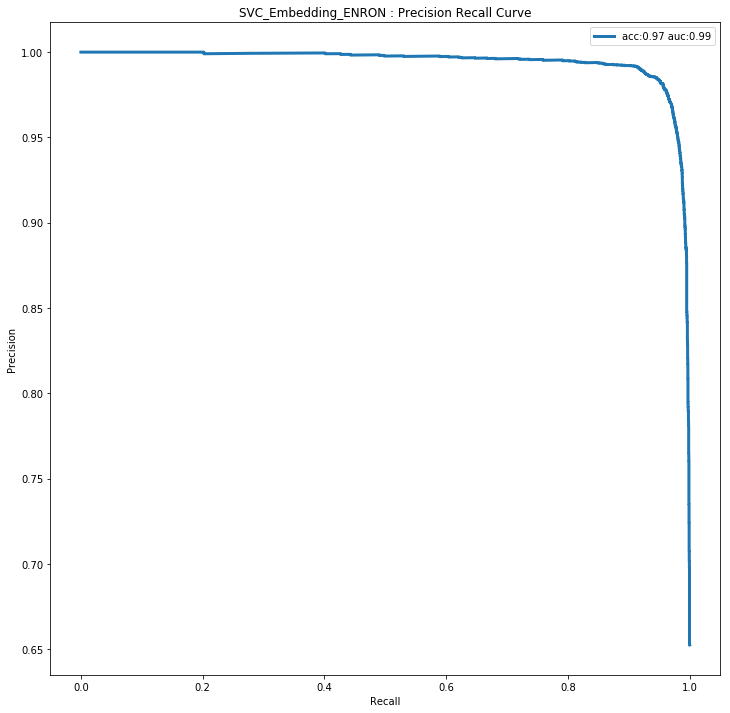

********************************************************************************
XGBoost_Embedding_ENRON
********************************************************************************
Log Loss :  1.7168908013789845
ROC AUC :  0.9886228944147586
Accuracy :  0.9502915307836742
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      4918
         1.0       0.95      0.95      0.95      5201

   micro avg       0.95      0.95      0.95     10119
   macro avg       0.95      0.95      0.95     10119
weighted avg       0.95      0.95      0.95     10119



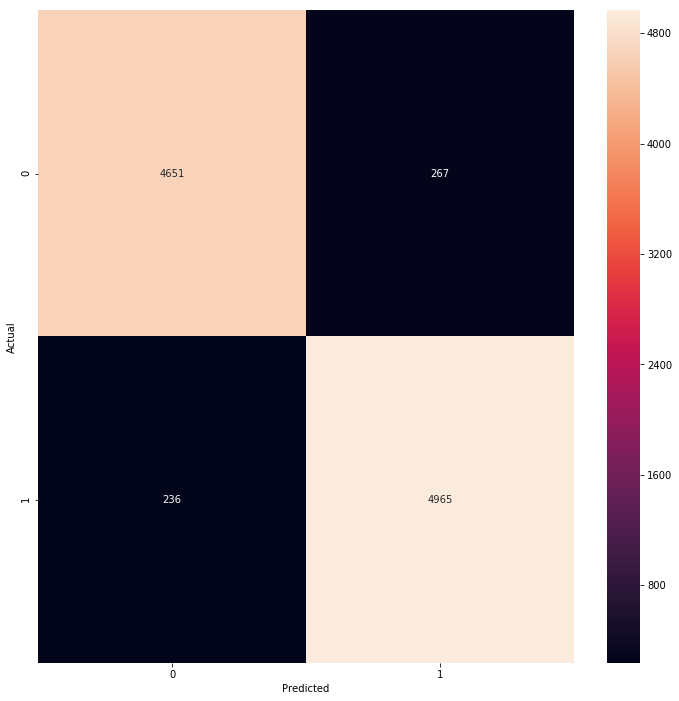

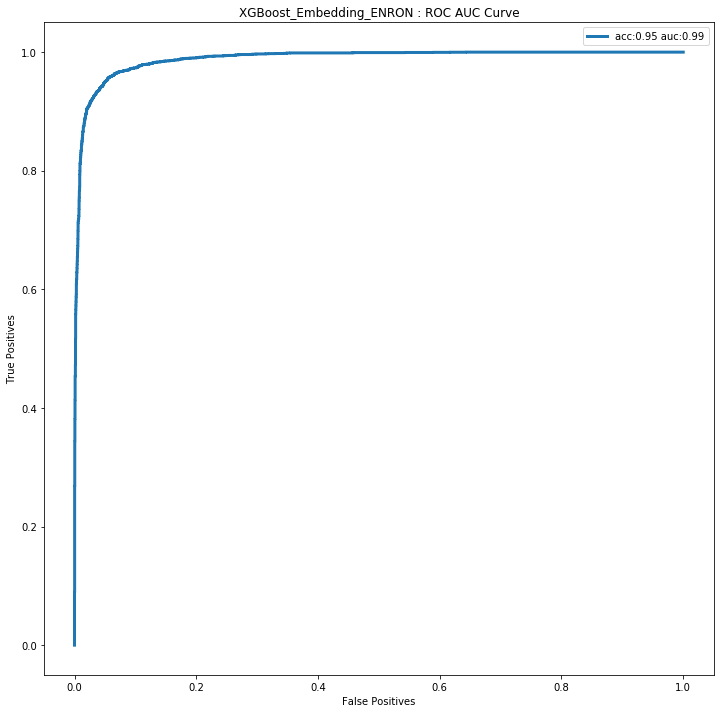

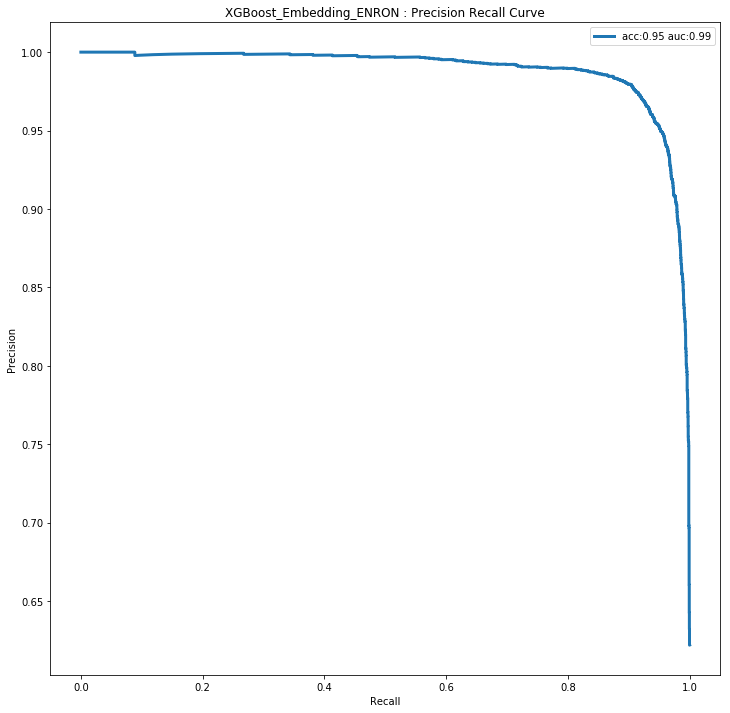

********************************************************************************
RandomForest_Embedding_ENRON
********************************************************************************
Log Loss :  2.597519190789792
ROC AUC :  0.9790684706596371
Accuracy :  0.9247949402114833
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      4918
         1.0       0.93      0.92      0.93      5201

   micro avg       0.92      0.92      0.92     10119
   macro avg       0.92      0.92      0.92     10119
weighted avg       0.92      0.92      0.92     10119



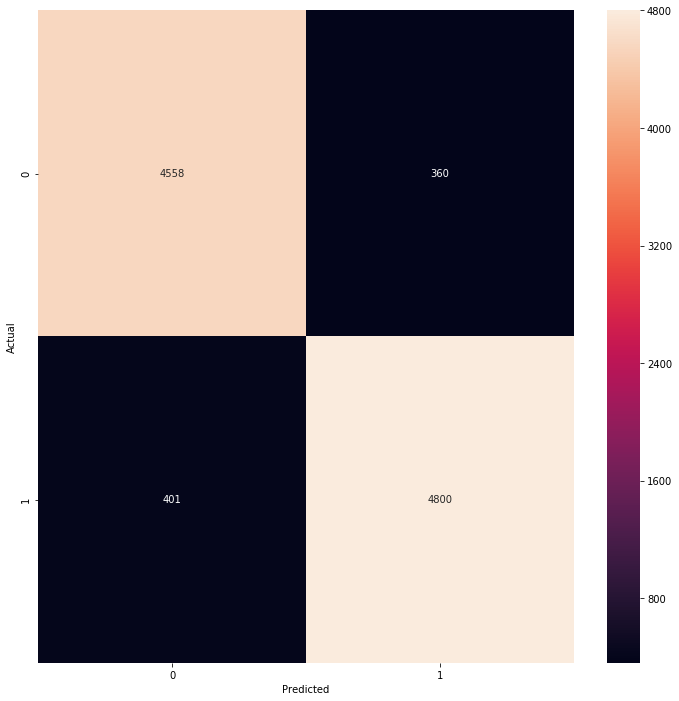

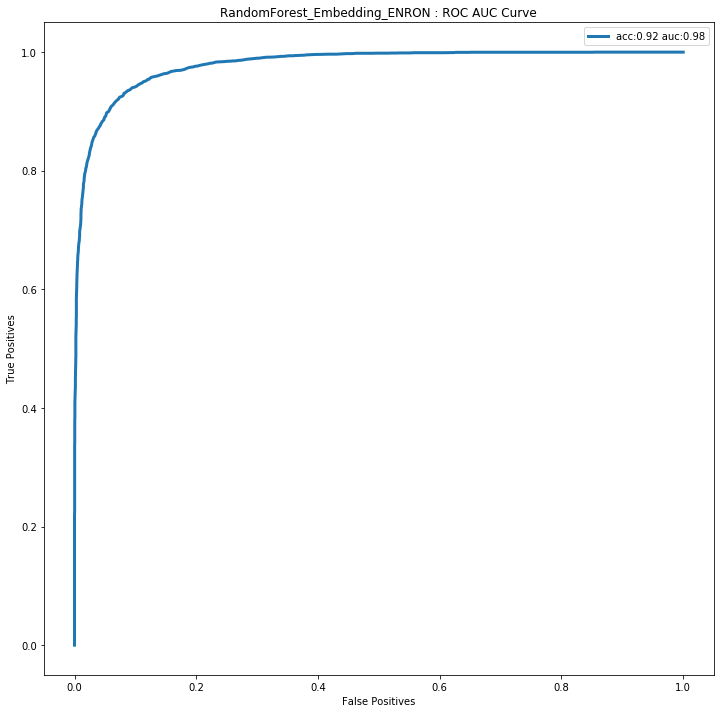

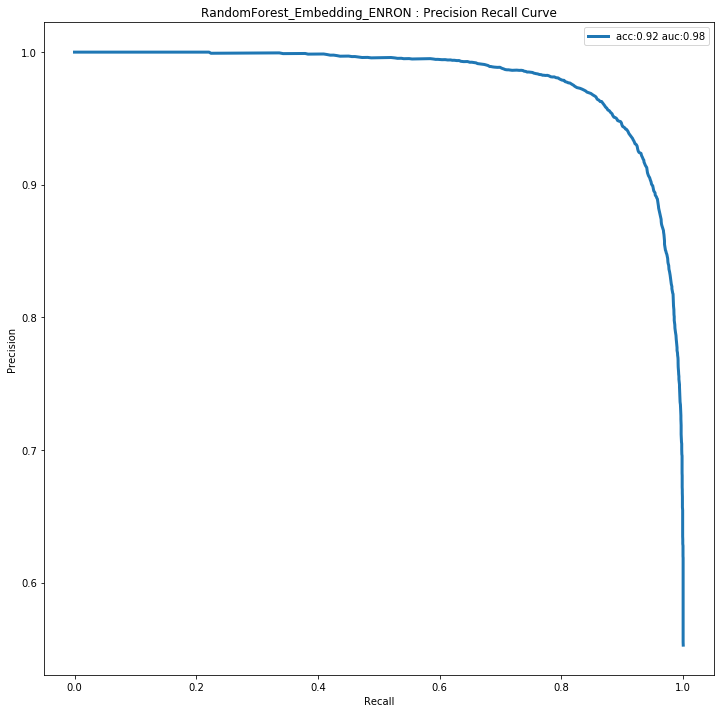

In [42]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_glove, y_test)

## 4. Embeddings with Dense Network

In [43]:
grids = {}
num_max = 20000
le = LabelEncoder()
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(train_x_cleaned)
train_x_dense = tok.texts_to_matrix(train_x_cleaned,mode='count')
test_x_dense = tok.texts_to_matrix(test_x_cleaned,mode='count')
print(y_train.shape,train_x_dense.shape, y_test.shape, test_x_dense.shape)

(23597,) (23597, 20000) (10119,) (10119, 20000)


In [44]:
%%time
dense_model = get_dense_model(num_max)
dense_model.fit(train_x_dense,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['DNN_'+dataset] = copy.deepcopy(dense_model)

gc.enable(); gc.collect();

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
compile done
Instructions for updating:
Use tf.cast instead.
Train on 18877 samples, validate on 4720 samples
Epoch 1/10
18877/18877 [==============================] - 17s 897us/step - loss: 0.1262 - acc: 0.9534 - val_loss: 0.4804 - val_acc: 0.7653
Epoch 2/10
18877/18877 [==============================] - 12s 610us/step - loss: 0.0194 - acc: 0.9945 - val_loss: 0.6823 - val_acc: 0.7939
Epoch 3/10
18877/18877 [==============================] - 12s 611us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 1.6362 - val_acc: 0.7992
Epoch 4/10
18877/18877 [==============================] - 12s 610us/step - loss: 0.0029 - acc: 0.9997 - val_loss: 1.5179 - val_acc: 0.8051
Epoch 5/10
18877/18877 [==============================] - 12s 612us/step - loss: 0.0018 - acc: 0.9999 - val_loss: 1.5547 - val_acc: 0.8212
Epoch 6/

## Visualise Shannon and Relative entropies for various models

********************************************************************************
DNN_ENRON
********************************************************************************
Mean Shannon Entropy :  0.0037513692
Mean Relative Entropy :  0.37042818338925787
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
12     0.225     2.823     1.0       0       0.941   5.941e-02
65     0.000     6.000     1.0       0       1.000   0.000e+00
74     0.002     6.000     1.0       0       1.000   1.794e-04
91     0.000     6.000     1.0       0       1.000   0.000e+00
124    0.000     6.000     1.0       0       1.000   0.000e+00
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10112      0.0       6.0     0.0       1         0.0         1.0
10113      0.0       6.0     0.0       1         0.0         1.0
10114      0.0       6.0     0.0       1         0.0         1.0
10116      0.0       6.0     0.0       1         0.0         1.0
10118      0.0       6.

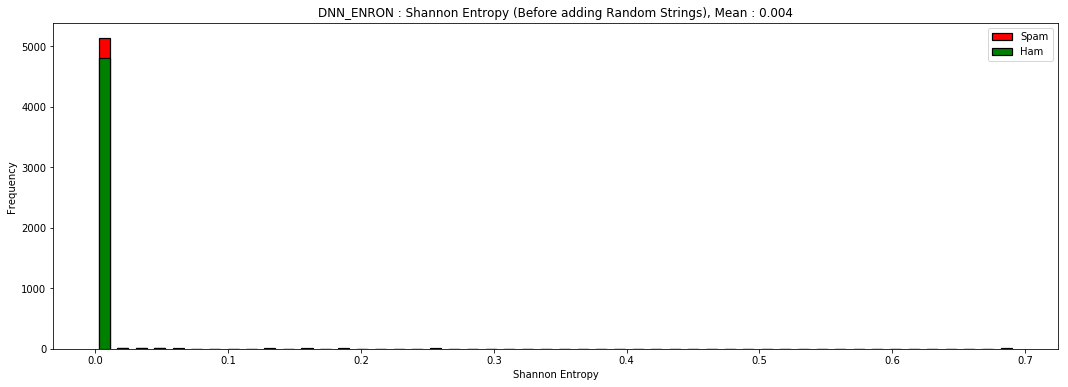

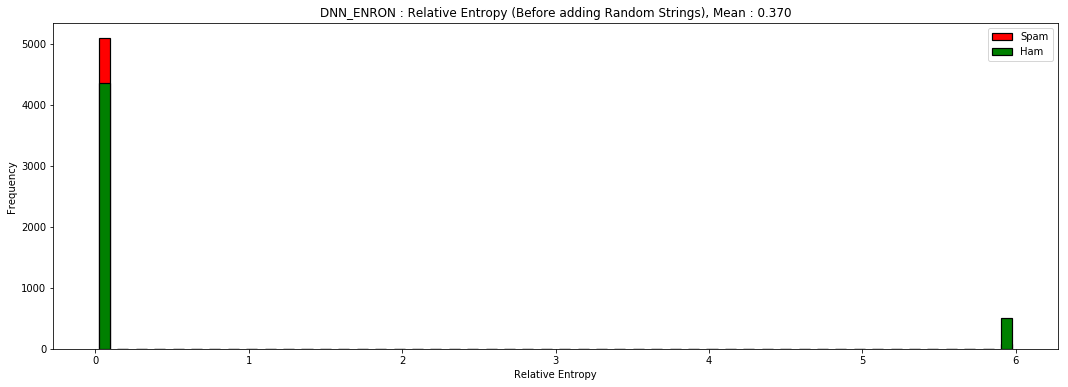

In [45]:
visualise_entropies(dataset, test_x_dense, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
DNN_ENRON
********************************************************************************
Log Loss :  2.245968914321813
ROC AUC :  0.9497232990589994
Accuracy :  0.9349738116414665
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      4918
         1.0       0.90      0.98      0.94      5201

   micro avg       0.93      0.93      0.93     10119
   macro avg       0.94      0.93      0.93     10119
weighted avg       0.94      0.93      0.93     10119



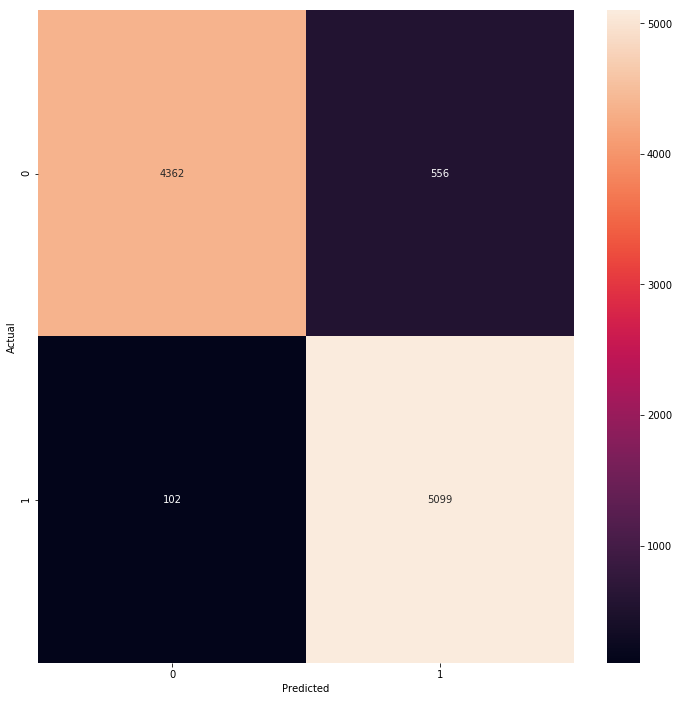

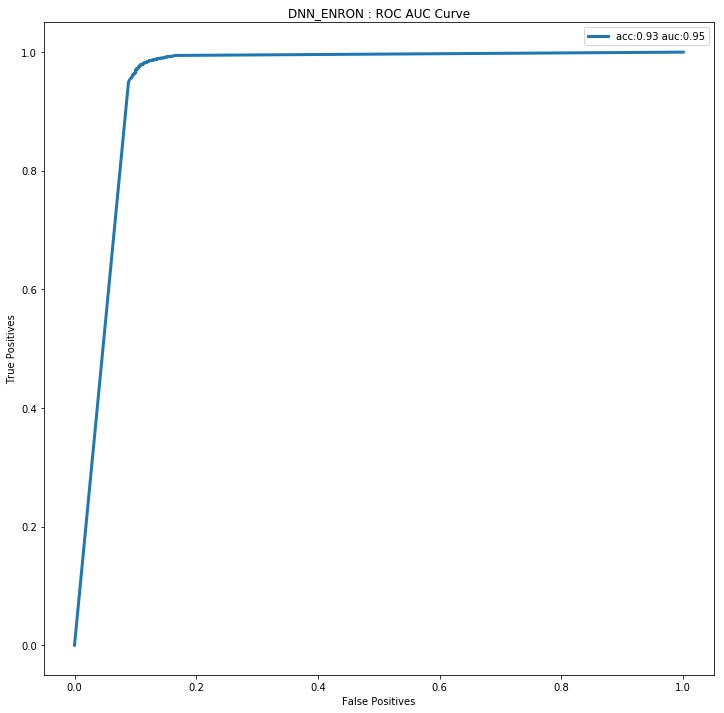

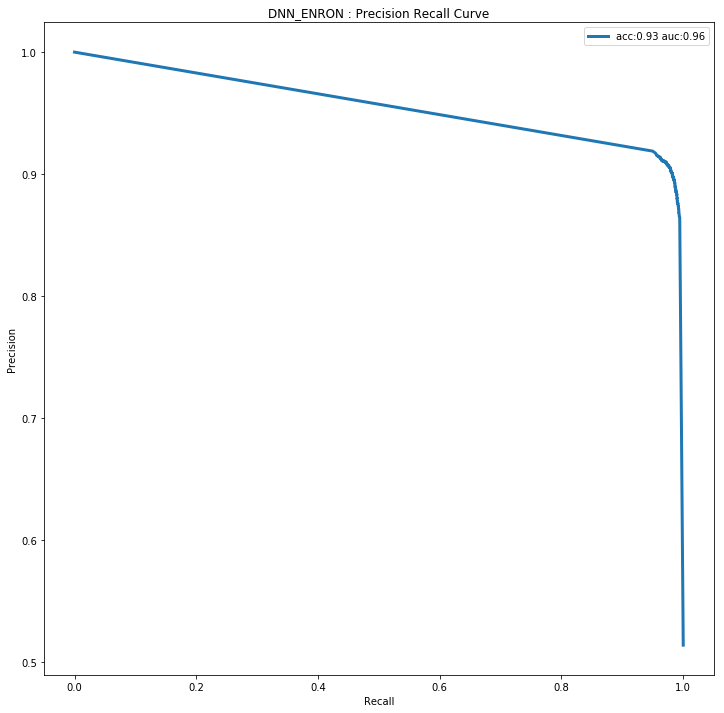

In [46]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_dense, y_test)

## Adding Meaningful Strings to Test Data

In [47]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
test_x_with_random_strings_dense = tok.texts_to_matrix(test_x_with_random_strings,mode='count')

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
DNN_ENRON
********************************************************************************
Mean Shannon Entropy :  0.0032378784
Mean Relative Entropy :  0.37966164762047033
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
65     0.000       6.0     1.0       0         1.0   0.000e+00
74     0.002       6.0     1.0       0         1.0   1.960e-04
91     0.000       6.0     1.0       0         1.0   0.000e+00
124    0.000       6.0     1.0       0         1.0   0.000e+00
229    0.001       6.0     1.0       0         1.0   1.150e-04
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10112      0.0       6.0     0.0       1         0.0         1.0
10113      0.0       6.0     0.0       1         0.0         1.0
10114      0.0       6.0     0.0       1         0.0         1.0
10116      0.0       6.0     0.0       1         0.0         1.0
10118      0.0       6.

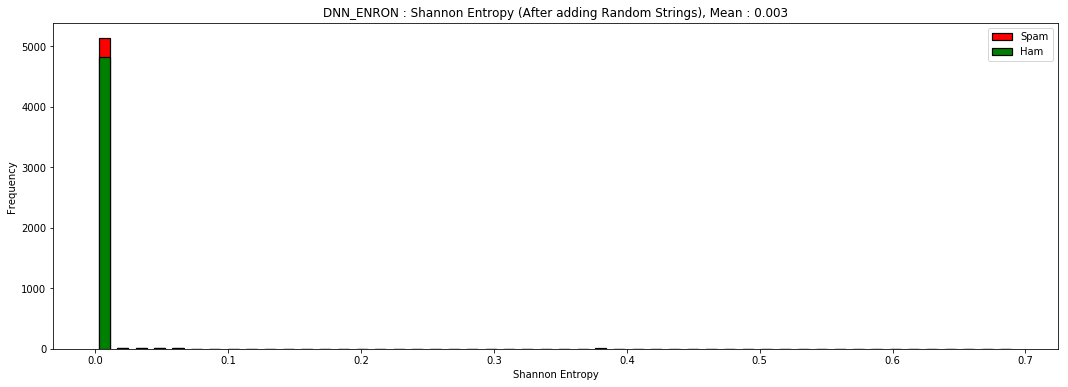

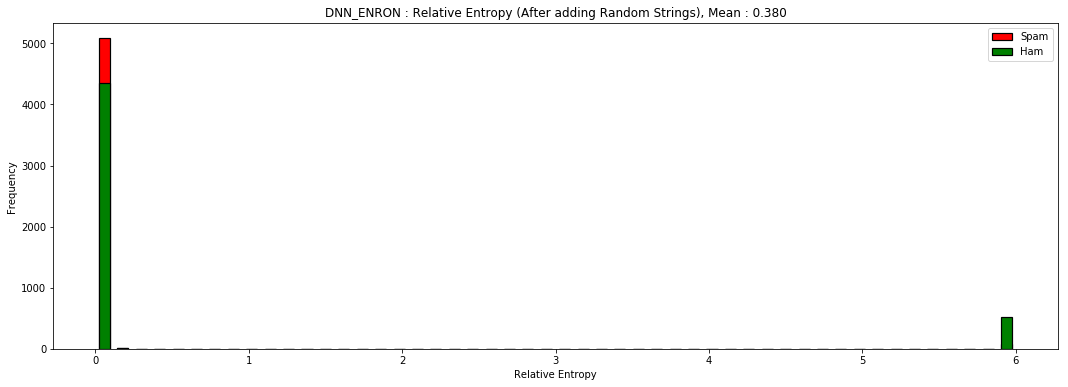

In [48]:
visualise_entropies(dataset, test_x_with_random_strings_dense, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
DNN_ENRON
********************************************************************************
Log Loss :  2.2732757832943977
ROC AUC :  0.9475572236045887
Accuracy :  0.9341832196857397
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      4918
         1.0       0.90      0.98      0.94      5201

   micro avg       0.93      0.93      0.93     10119
   macro avg       0.94      0.93      0.93     10119
weighted avg       0.94      0.93      0.93     10119



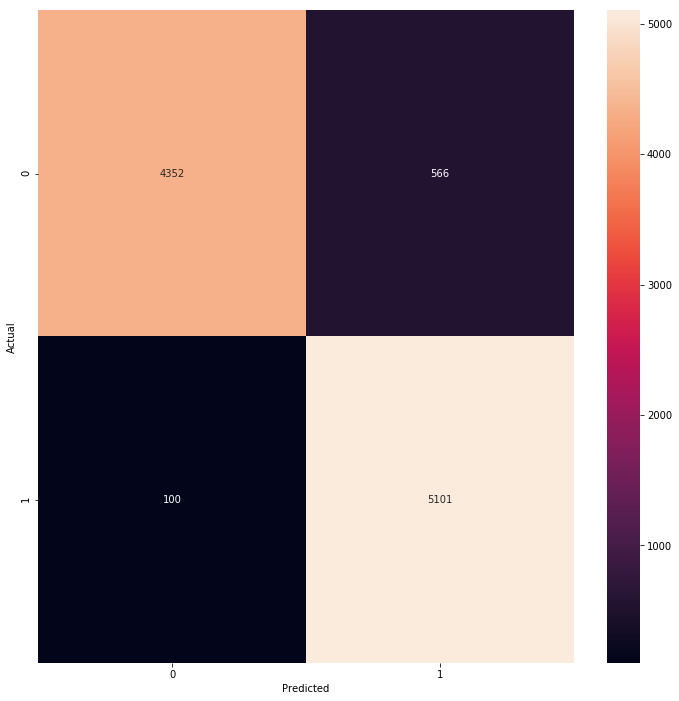

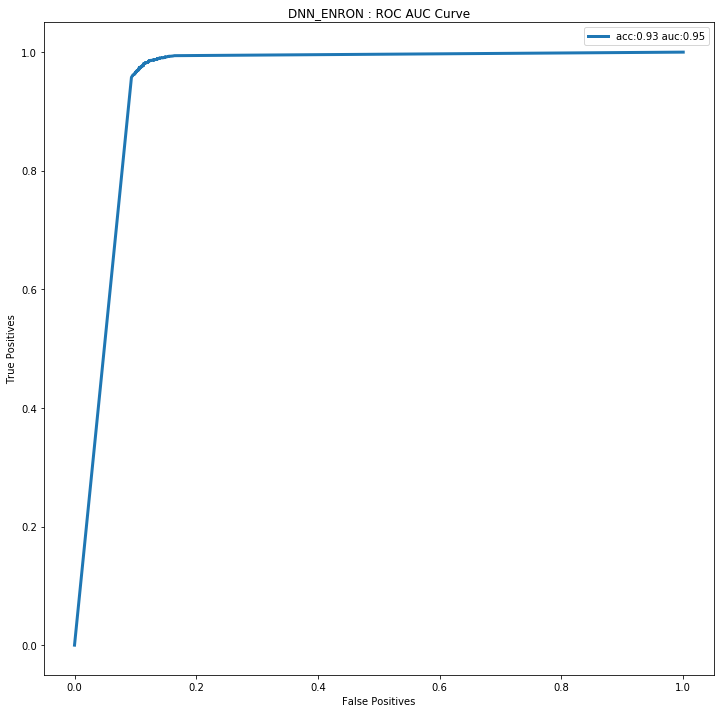

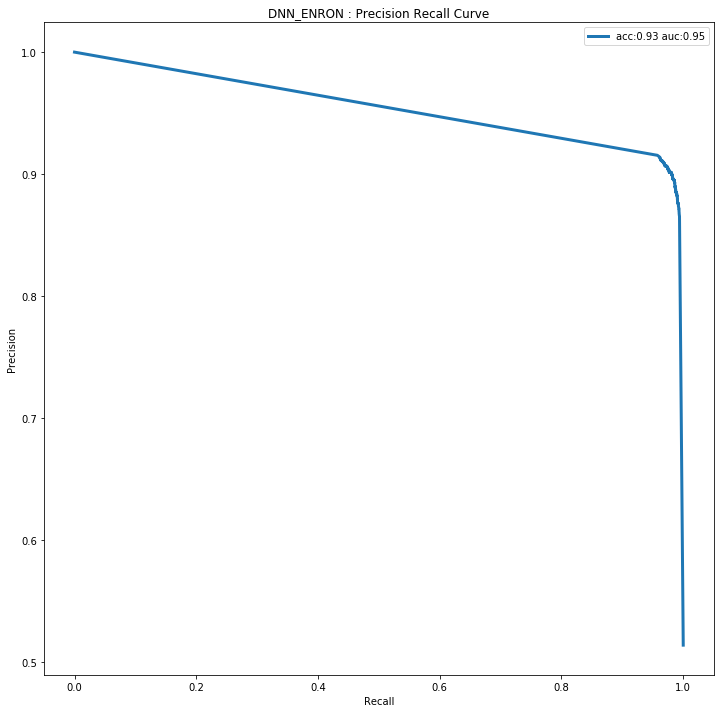

In [49]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_dense, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [50]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
test_x_with_random_strings_dense = tok.texts_to_matrix(test_x_with_random_strings,mode='count')

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
DNN_ENRON
********************************************************************************
Mean Shannon Entropy :  0.00072747114
Mean Relative Entropy :  2.9161337530008025
Head 5 : 
        Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
5201  7.275e-04       6.0     0.0       1   6.872e-05         1.0
5202  7.275e-04       6.0     0.0       1   6.872e-05         1.0
5203  7.275e-04       6.0     0.0       1   6.872e-05         1.0
5204  7.275e-04       6.0     0.0       1   6.872e-05         1.0
5205  7.275e-04       6.0     0.0       1   6.872e-05         1.0
Tail 5 : 
         Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10114  7.275e-04       6.0     0.0       1   6.872e-05         1.0
10115  7.275e-04       6.0     0.0       1   6.872e-05         1.0
10116  7.280e-04       6.0     0.0       1   6.878e-05         1.0
10117  7.280e-04       6.0     0.0       1   6.878e-05        

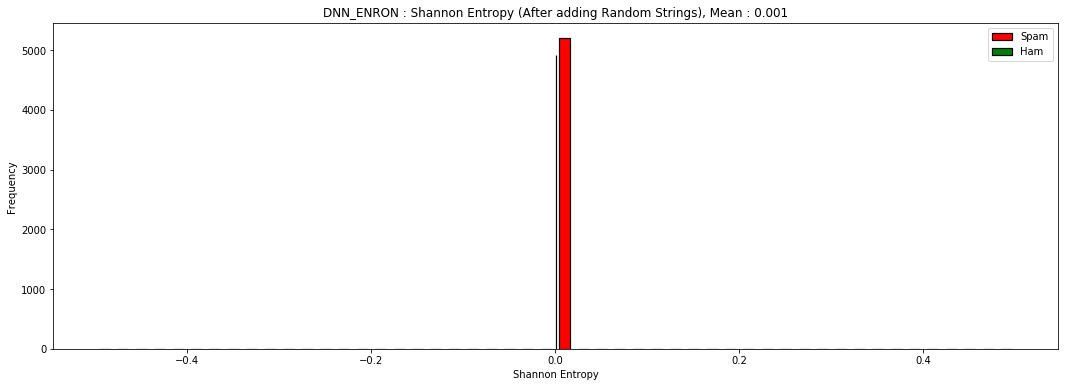

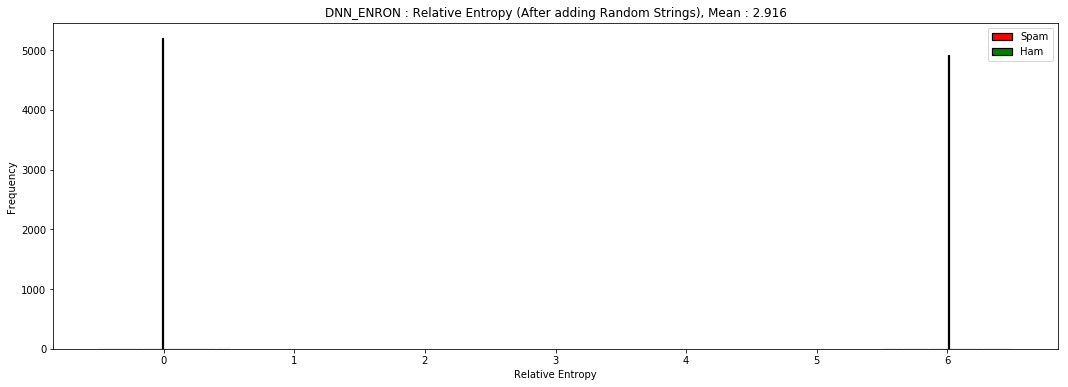

In [51]:
visualise_entropies(dataset, test_x_with_random_strings_dense, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
DNN_ENRON
********************************************************************************
Log Loss :  16.78680054652954
ROC AUC :  0.5003050020333468
Accuracy :  0.5139835952169187
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4918
         1.0       0.51      1.00      0.68      5201

   micro avg       0.51      0.51      0.51     10119
   macro avg       0.26      0.50      0.34     10119
weighted avg       0.26      0.51      0.35     10119



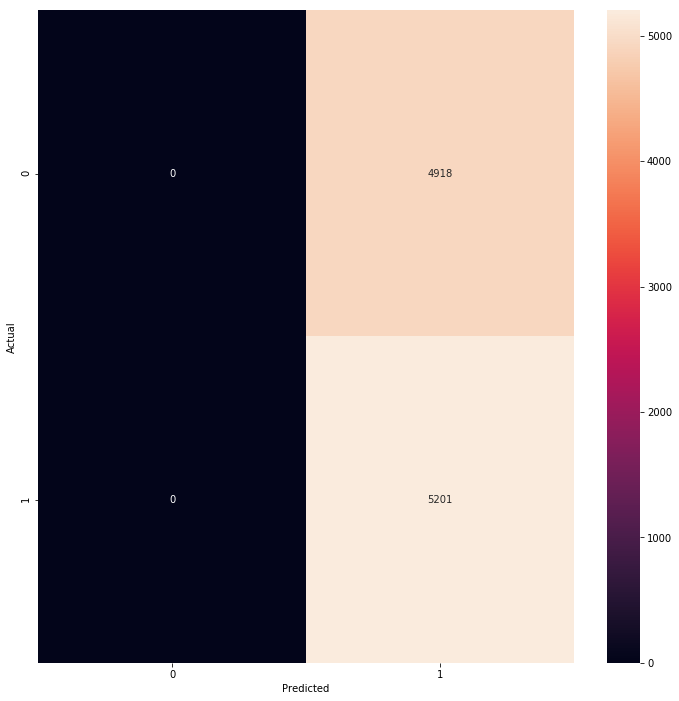

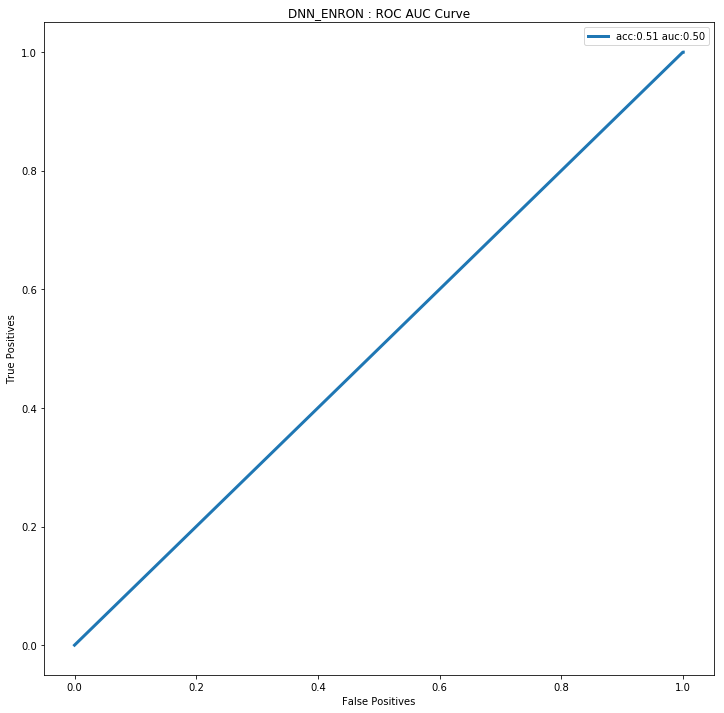

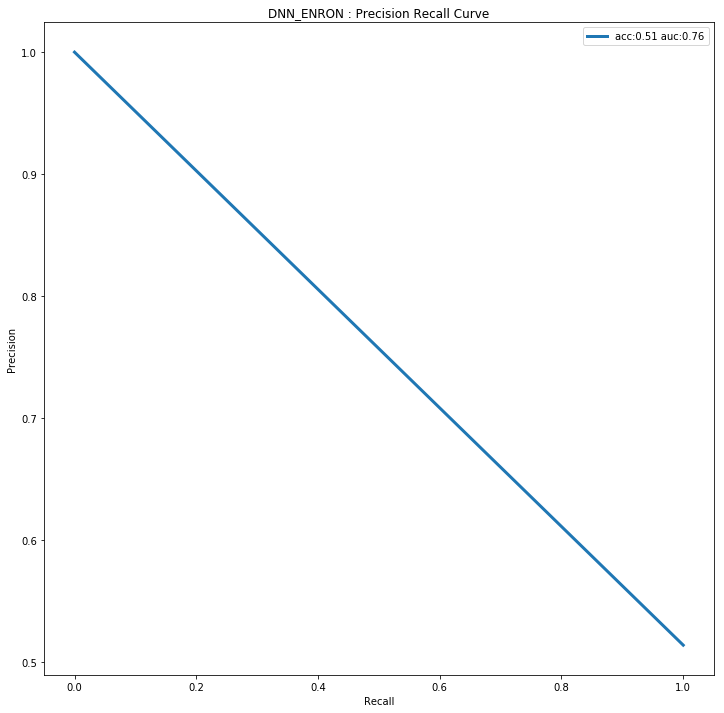

In [52]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_dense, y_test)

## 5. Embeddings with CNNs
### Initial Data Cleaning

In [53]:
grids = {}
max_len = 300
cnn_train_seq = tok.texts_to_sequences(train_x_cleaned)
cnn_test_seq = tok.texts_to_sequences(test_x_cleaned)
#print(cnn_texts_seq[0])
train_x_cnn = sequence.pad_sequences(cnn_train_seq,maxlen=max_len)
test_x_cnn = sequence.pad_sequences(cnn_test_seq,maxlen=max_len)
#print(train_x_cnn[0])
print(train_x_cnn.shape)

(23597, 300)


## CNN Version 1
### Training Model

In [54]:
%%time
cnn_v1 = get_cnn_model_v1(max_len)
cnn_v1.fit(train_x_cnn,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['CNN_V1_'+dataset] = copy.deepcopy(cnn_v1)

gc.enable(); gc.collect();

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 18877 samples, validate on 4720 samples
Epoch 1/10
18877/18877 [==============================] - 4s 210us/step - loss: 0.5071 - acc: 0.8910 - val_loss: 1.9916 - val_acc: 0.7451
Epoch 2/10
18877/18877 [==============================] - 3s 174us/step - loss: 0.5621 - acc: 0.9341 - val_loss: 2.1327 - val_acc: 0.7767
Epoch 3/10
18877/18877 [==============================] - 3s 174us/step - loss: 0.6327 - acc: 0.9361 - val_loss: 4.7088 - val_acc: 0.6375
Epoch 4/10
18877/18877 [==============================] - 3s 177us/step - loss: 1.1429 - acc: 0.9079 - val_loss: 6.0084 - val_acc: 0.5394
Epoch 5/10
18877/18877 [==============================] - 3s 174us/step - loss: 1.1130 - acc: 0.9094 - val_loss: 6.4765 - val_acc: 0.5097
Epoch 6/10
18877/18877 [==============================] - 3s 174us/step - loss: 1.6403 - acc: 0.8798 - val_loss: 6.6275 - val_acc: 0.5269
Epoch 7/10
18877/18877 [=====================

## Visualise Shannon and Relative entropies for various models

********************************************************************************
CNN_V1_ENRON
********************************************************************************
Mean Shannon Entropy :  0.025697436
Mean Relative Entropy :  1.3317587209604513
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
28    0.000     6.000     1.0       0       1.000       0.000
31    0.000     6.000     1.0       0       1.000       0.000
56    0.582     1.312     1.0       0       0.731       0.269
61    0.000     6.000     1.0       0       1.000       0.000
63    0.000     6.000     1.0       0       1.000       0.000
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10112      0.0       6.0     0.0       1         0.0         1.0
10113      0.0       6.0     0.0       1         0.0         1.0
10114      0.0       6.0     0.0       1         0.0         1.0
10116      0.0       6.0     0.0       1         0.0         1.0
10118      0.0       6.0    

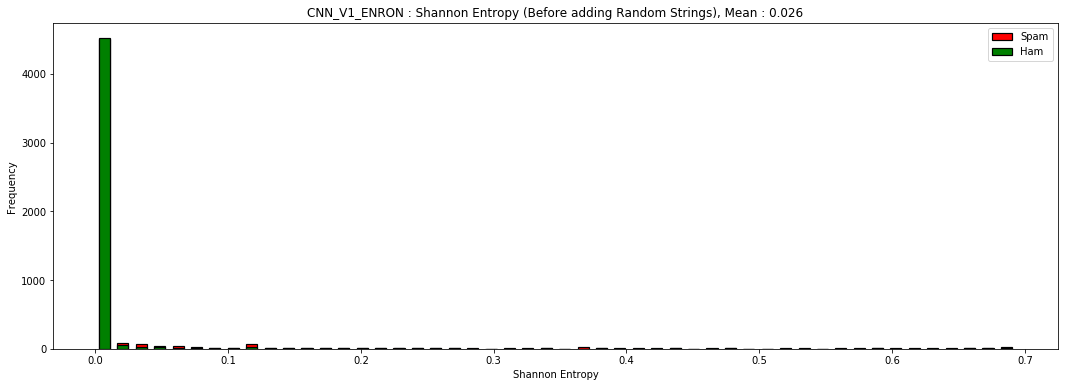

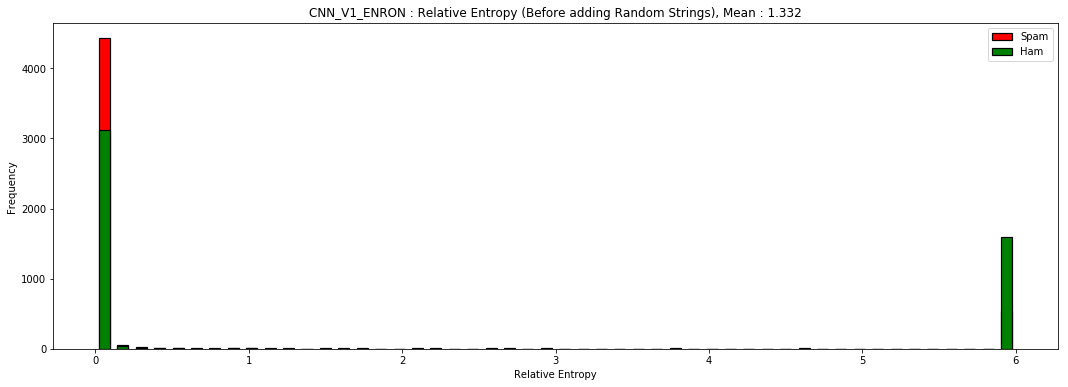

In [55]:
visualise_entropies(dataset, test_x_cnn, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
CNN_V1_ENRON
********************************************************************************
Log Loss :  8.12028172228994
ROC AUC :  0.7362197645696283
Accuracy :  0.7648977171657279
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.65      0.73      4918
         1.0       0.72      0.87      0.79      5201

   micro avg       0.76      0.76      0.76     10119
   macro avg       0.78      0.76      0.76     10119
weighted avg       0.78      0.76      0.76     10119



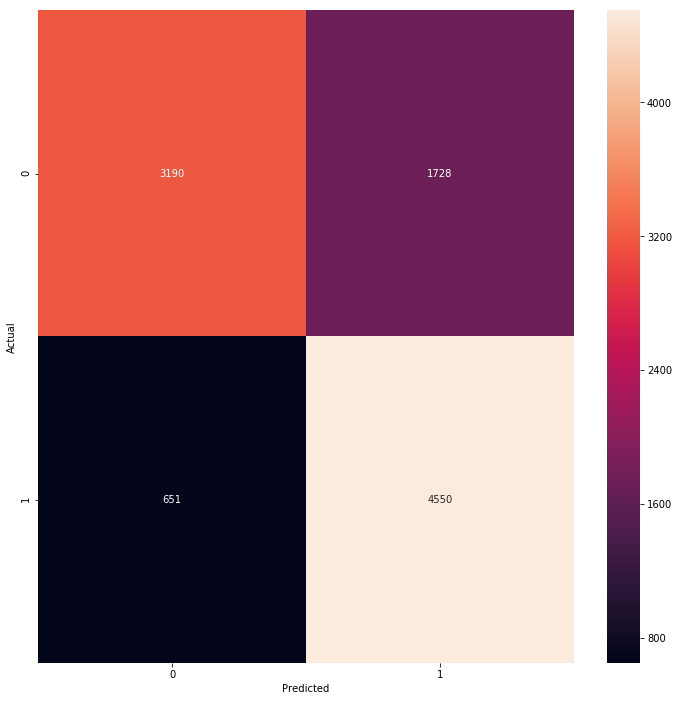

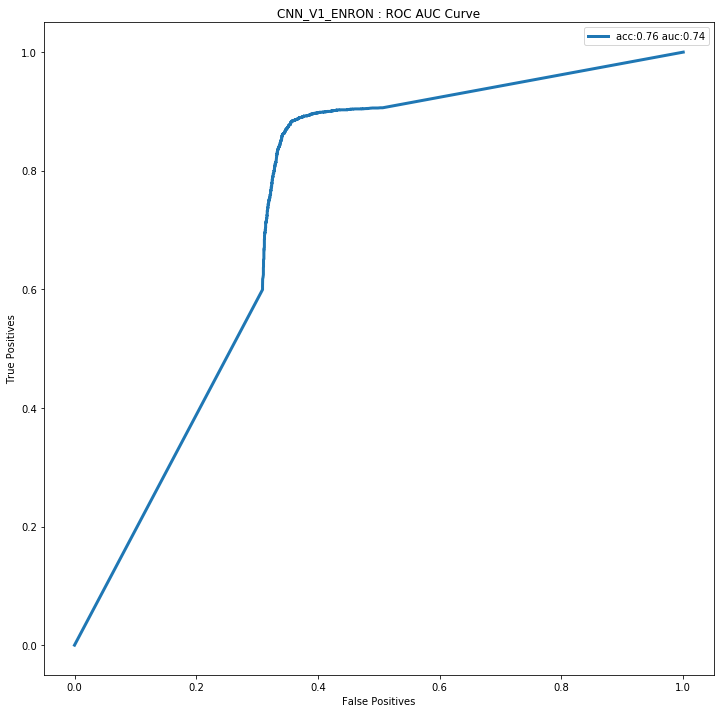

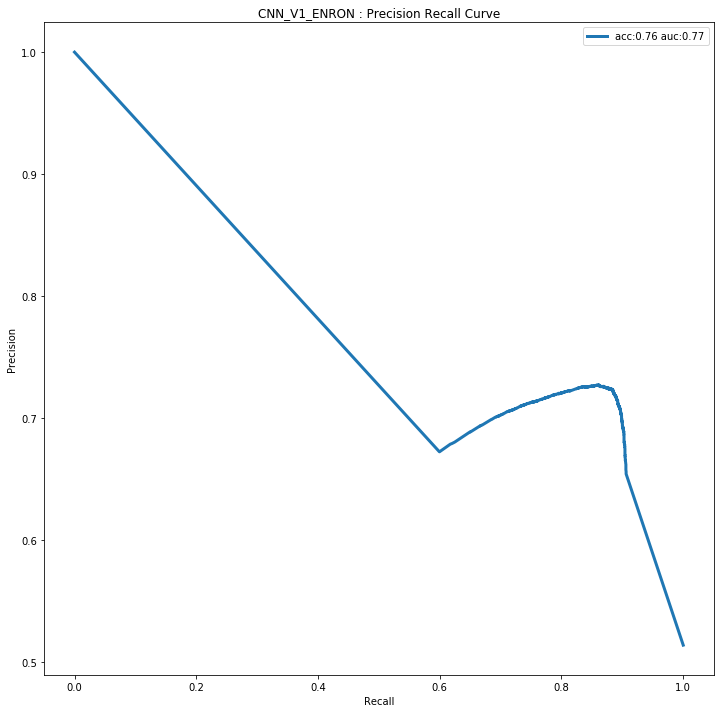

In [56]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cnn, y_test)

## Adding Meaningful Strings to Test Data

In [57]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V1_ENRON
********************************************************************************
Mean Shannon Entropy :  0.026021607
Mean Relative Entropy :  1.3367929501925362
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
28    0.000     6.000     1.0       0       1.000       0.000
31    0.000     6.000     1.0       0       1.000       0.000
56    0.592     1.275     1.0       0       0.721       0.279
61    0.000     6.000     1.0       0       1.000       0.000
63    0.000     6.000     1.0       0       1.000       0.000
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10112      0.0       6.0     0.0       1         0.0         1.0
10113      0.0       6.0     0.0       1         0.0         1.0
10114      0.0       6.0     0.0       1         0.0         1.0
10116      0.0       6.0     0.0       1         0.0         1.0
10118      0.0       6.0    

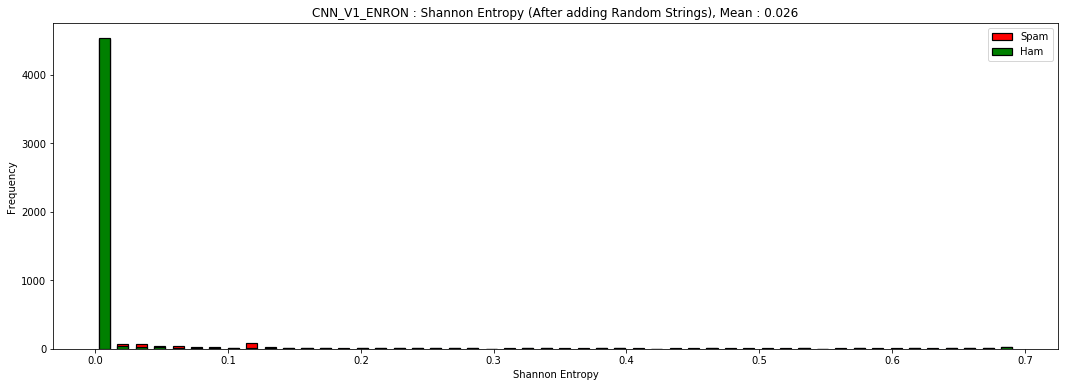

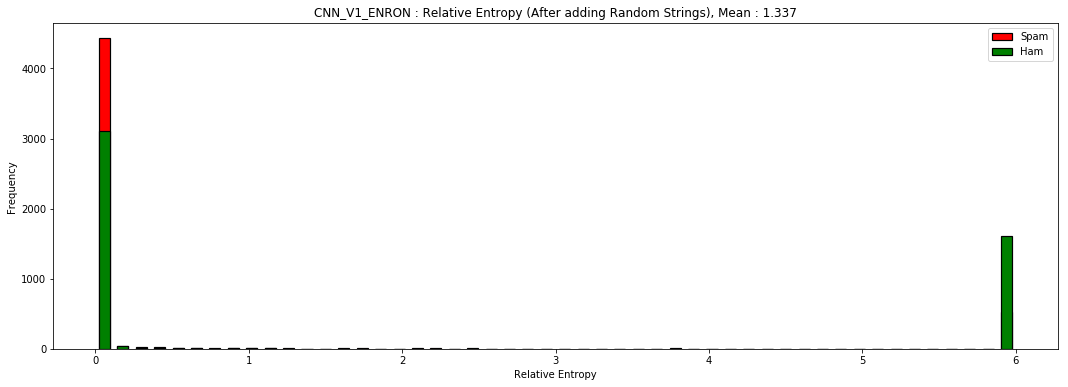

In [58]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V1_ENRON
********************************************************************************
Log Loss :  8.133934919717994
ROC AUC :  0.7350374247640149
Accuracy :  0.7645024211878644
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.65      0.73      4918
         1.0       0.72      0.87      0.79      5201

   micro avg       0.76      0.76      0.76     10119
   macro avg       0.78      0.76      0.76     10119
weighted avg       0.78      0.76      0.76     10119



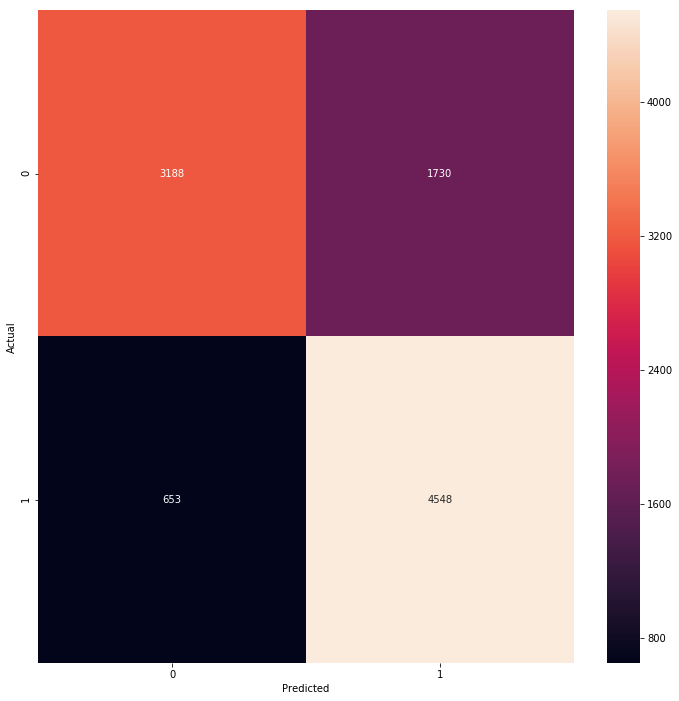

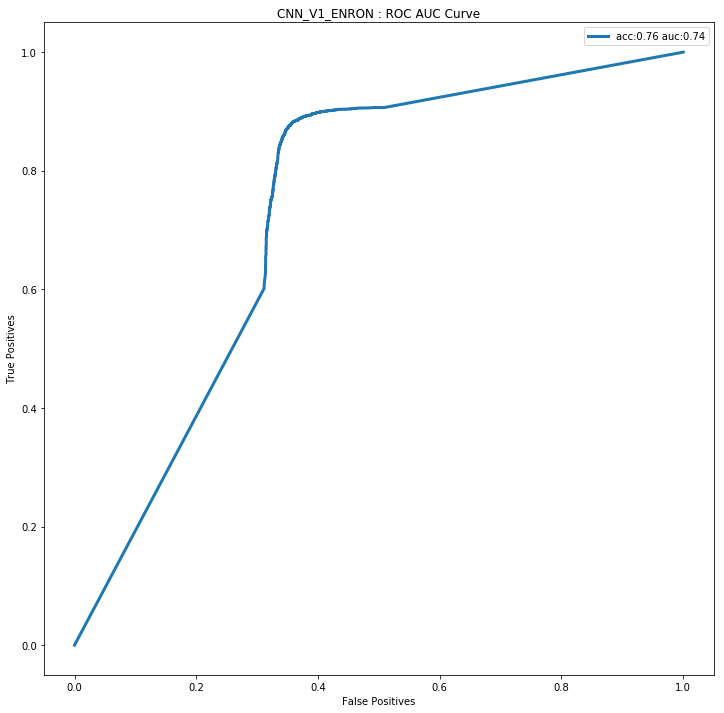

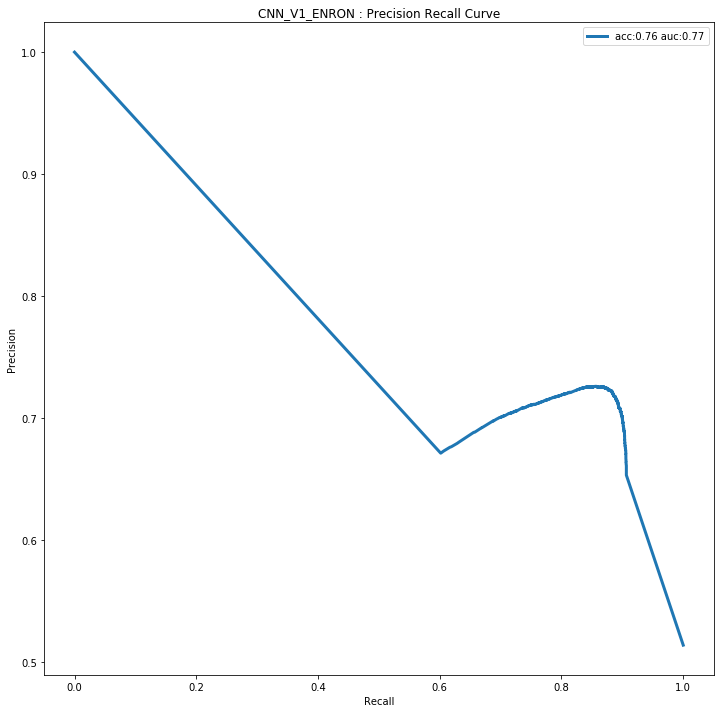

In [59]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [60]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V1_ENRON
********************************************************************************
Mean Shannon Entropy :  0.37991777
Mean Relative Entropy :  1.0739576415486622
Head 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
5201     0.38     2.067     0.0       1       0.127       0.873
5202     0.38     2.067     0.0       1       0.127       0.873
5203     0.38     2.067     0.0       1       0.127       0.873
5204     0.38     2.067     0.0       1       0.127       0.873
5205     0.38     2.067     0.0       1       0.127       0.873
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10114     0.38     2.067     0.0       1       0.127       0.873
10115     0.38     2.067     0.0       1       0.127       0.873
10116     0.38     2.067     0.0       1       0.127       0.873
10117     0.38     2.067     0.0       1       0.127       0.873
10118     0.38   

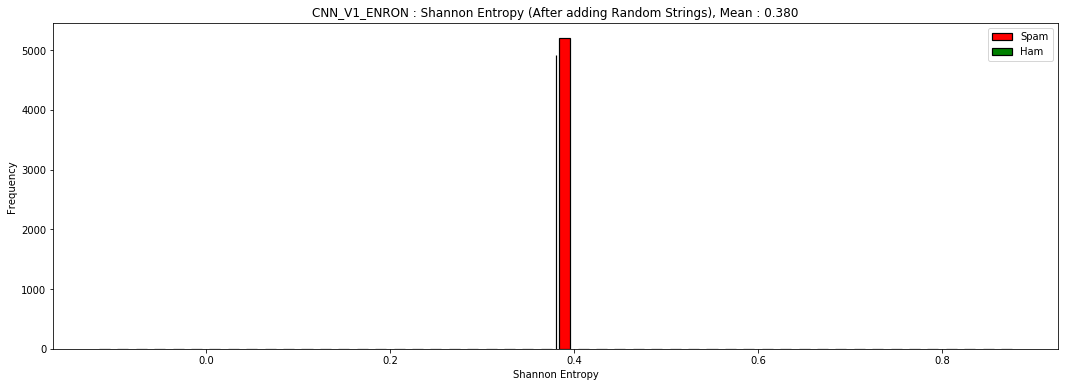

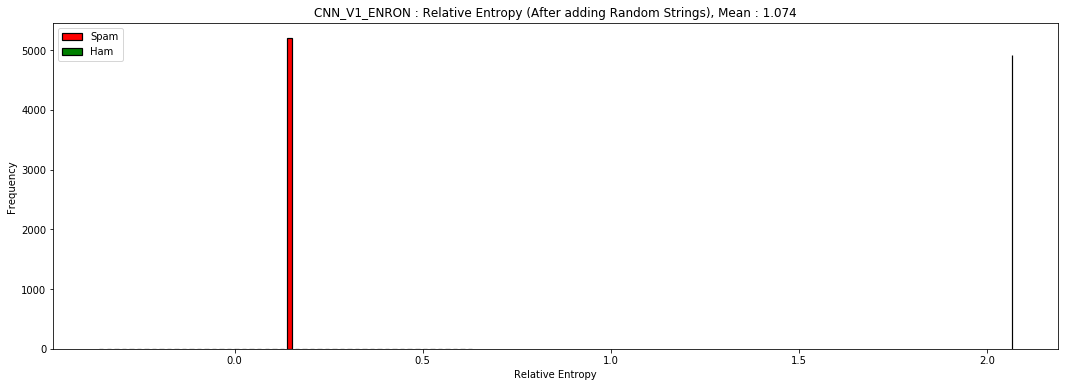

In [61]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V1_ENRON
********************************************************************************
Log Loss :  16.78680054652954
ROC AUC :  0.4996949979666531
Accuracy :  0.5139835952169187
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4918
         1.0       0.51      1.00      0.68      5201

   micro avg       0.51      0.51      0.51     10119
   macro avg       0.26      0.50      0.34     10119
weighted avg       0.26      0.51      0.35     10119



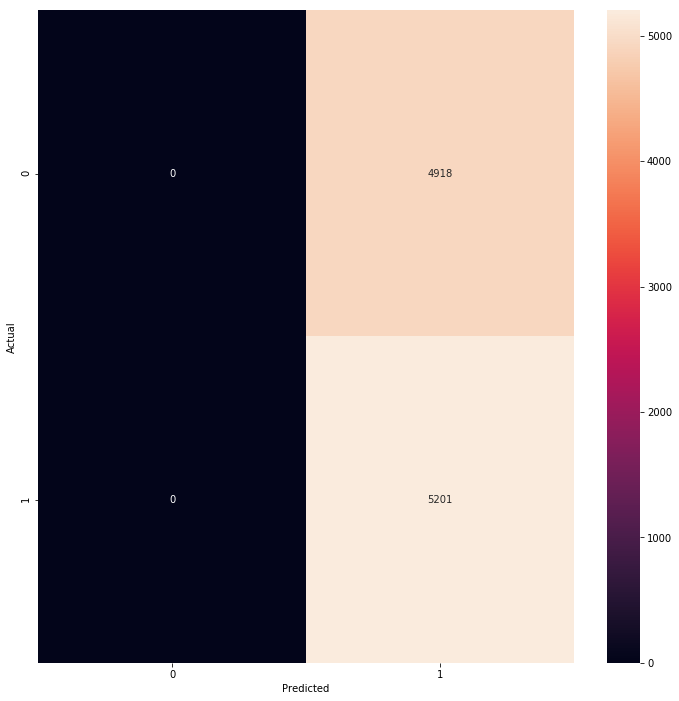

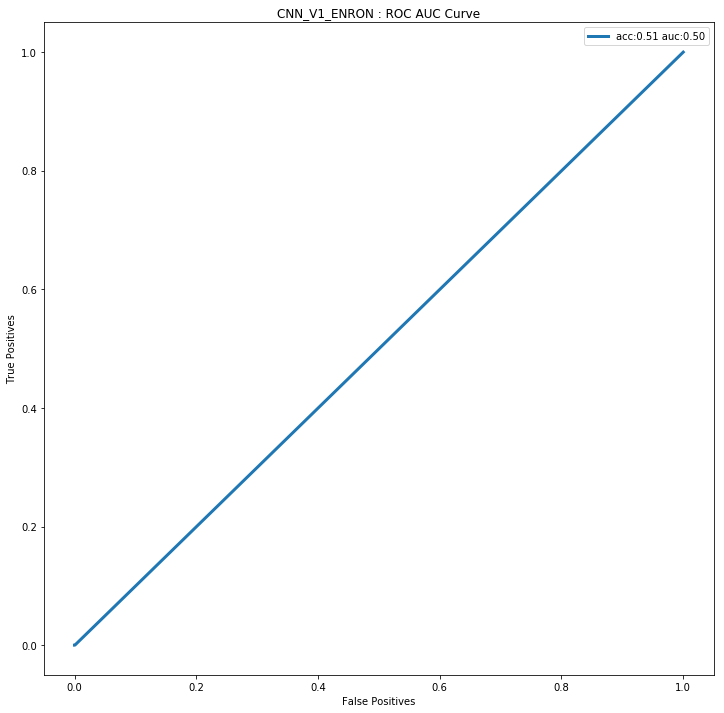

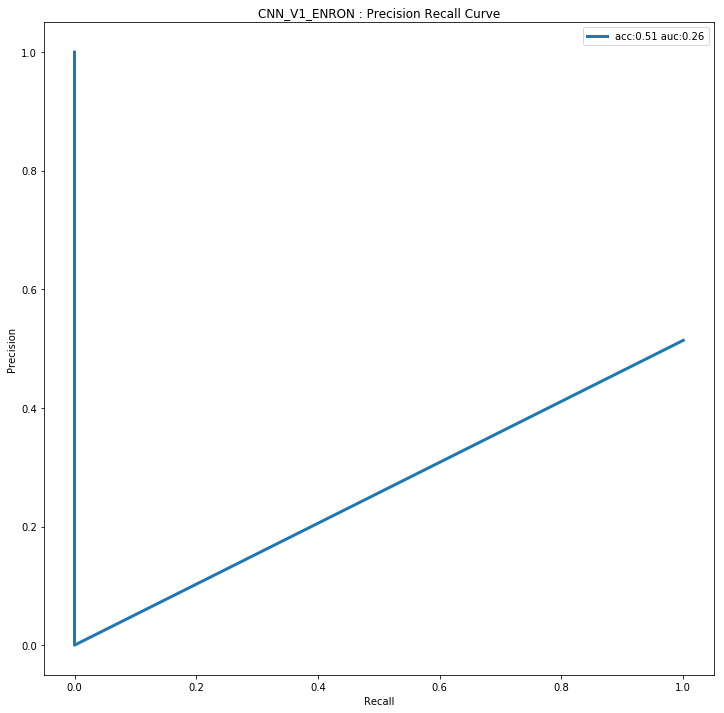

In [62]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## CNN Version 2
### Training Model

In [63]:
%%time
grids = {}
cnn_v2 = get_cnn_model_v2(max_len)
cnn_v2.fit(train_x_cnn,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['CNN_V2_'+dataset] = copy.deepcopy(cnn_v2)

gc.enable(); gc.collect();

Train on 18877 samples, validate on 4720 samples
Epoch 1/10
18877/18877 [==============================] - 4s 235us/step - loss: 0.2954 - acc: 0.8876 - val_loss: 0.6454 - val_acc: 0.7282
Epoch 2/10
18877/18877 [==============================] - 4s 193us/step - loss: 0.1326 - acc: 0.9522 - val_loss: 0.3929 - val_acc: 0.8297
Epoch 3/10
18877/18877 [==============================] - 4s 192us/step - loss: 0.1076 - acc: 0.9600 - val_loss: 0.5351 - val_acc: 0.7794
Epoch 4/10
18877/18877 [==============================] - 4s 195us/step - loss: 0.0983 - acc: 0.9650 - val_loss: 0.5037 - val_acc: 0.8426
Epoch 5/10
18877/18877 [==============================] - 4s 194us/step - loss: 0.0800 - acc: 0.9707 - val_loss: 0.9751 - val_acc: 0.6220
Epoch 6/10
18877/18877 [==============================] - 4s 192us/step - loss: 0.0736 - acc: 0.9737 - val_loss: 0.8774 - val_acc: 0.7790
Epoch 7/10
18877/18877 [==============================] - 4s 189us/step - loss: 0.0707 - acc: 0.9757 - val_loss: 1.1386 - v

## Visualise Shannon and Relative entropies for various models

********************************************************************************
CNN_V2_ENRON
********************************************************************************
Mean Shannon Entropy :  0.0544075
Mean Relative Entropy :  0.392611606321264
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
65     0.644     1.065     1.0       0       0.655       0.345
154    0.255     2.653     1.0       0       0.930       0.070
170    0.687     0.815     1.0       0       0.557       0.443
263    0.036     5.149     1.0       0       0.994       0.006
267    0.693     0.706     1.0       0       0.507       0.493
Tail 5 : 
         Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10112  5.586e-05       6.0     0.0       1   4.172e-06         1.0
10113  5.586e-05       6.0     0.0       1   4.172e-06         1.0
10114  1.403e-04       6.0     0.0       1   1.132e-05         1.0
10116  1.403e-04       6.0     0.0       1   1.132e-05         1.0
10118  5.586e-0

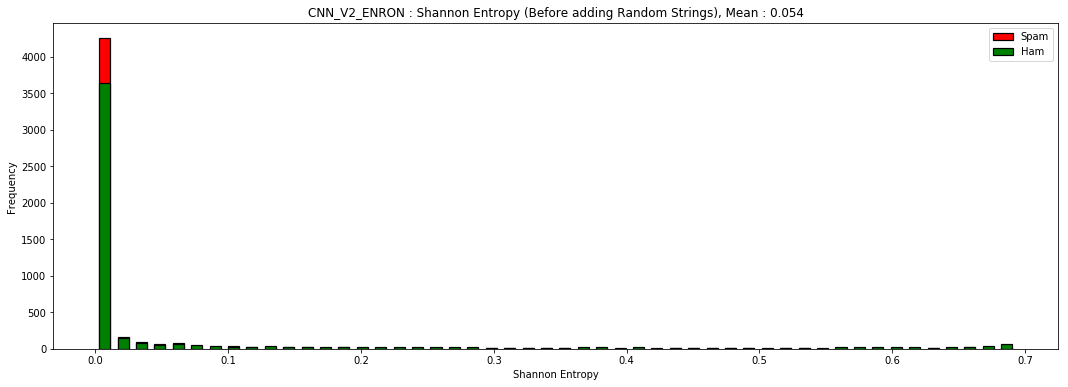

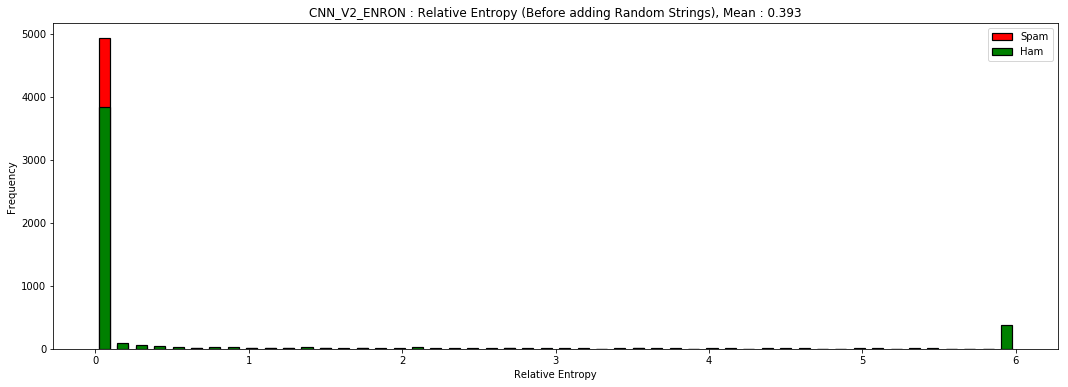

In [64]:
visualise_entropies(dataset, test_x_cnn, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
CNN_V2_ENRON
********************************************************************************
Log Loss :  3.324582178758894
ROC AUC :  0.9608075026082433
Accuracy :  0.9037454293902559
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89      4918
         1.0       0.86      0.98      0.91      5201

   micro avg       0.90      0.90      0.90     10119
   macro avg       0.91      0.90      0.90     10119
weighted avg       0.91      0.90      0.90     10119



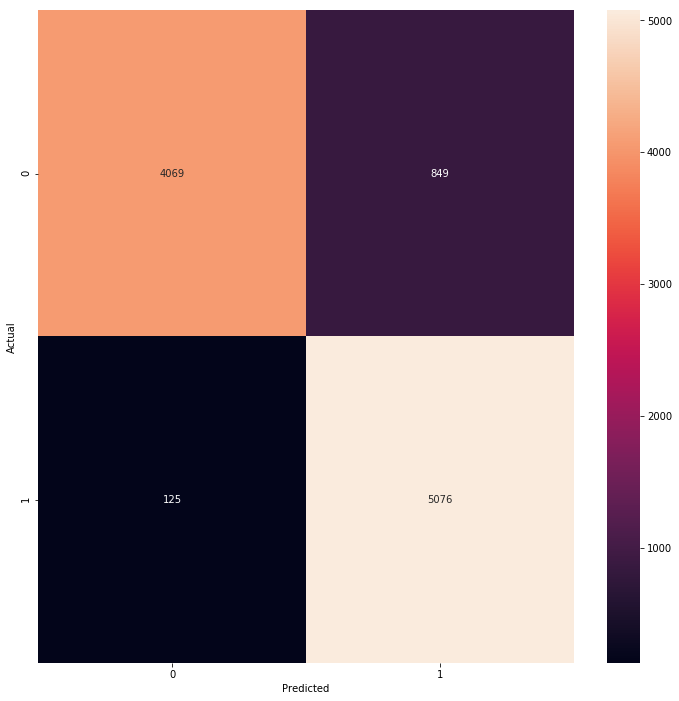

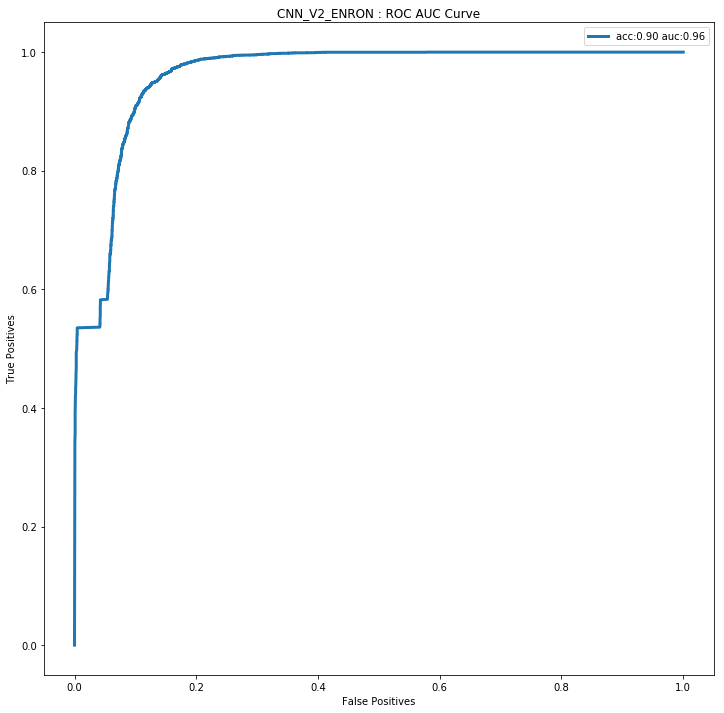

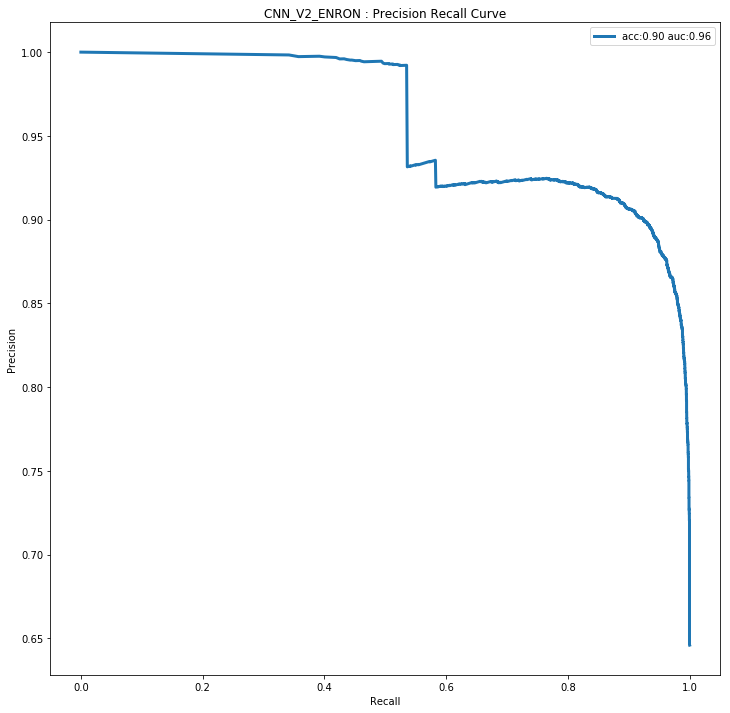

In [65]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cnn, y_test)

## Adding Meaningful Strings to Test Data

In [66]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V2_ENRON
********************************************************************************
Mean Shannon Entropy :  0.055368483
Mean Relative Entropy :  0.39633978600516556
Head 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
154  2.067e-01     2.941     1.0       0       0.947   5.279e-02
218  6.257e-01     1.144     1.0       0       0.682   3.185e-01
263  5.103e-04     6.000     1.0       0       1.000   4.649e-05
267  6.845e-01     0.834     1.0       0       0.566   4.344e-01
418  6.906e-01     0.767     1.0       0       0.536   4.644e-01
Tail 5 : 
         Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10112  9.048e-05       6.0     0.0       1   7.033e-06         1.0
10113  9.048e-05       6.0     0.0       1   7.033e-06         1.0
10114  1.818e-04       6.0     0.0       1   1.502e-05         1.0
10116  1.818e-04       6.0     0.0       1   1.502e-05         1.0

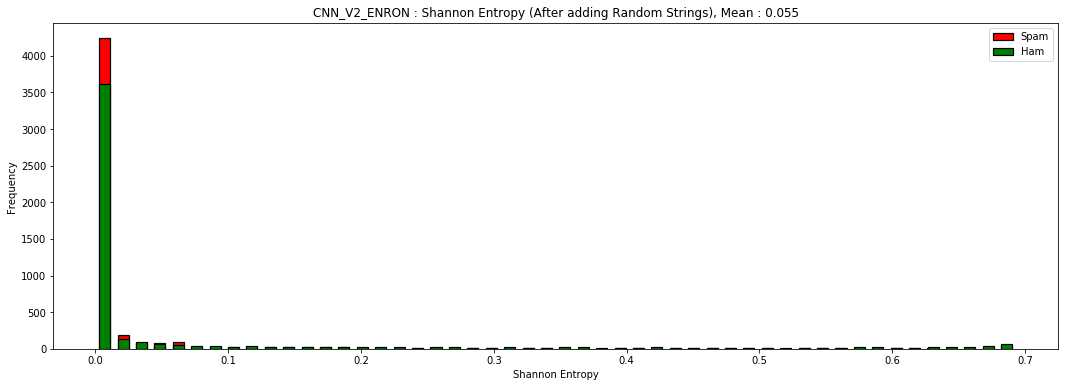

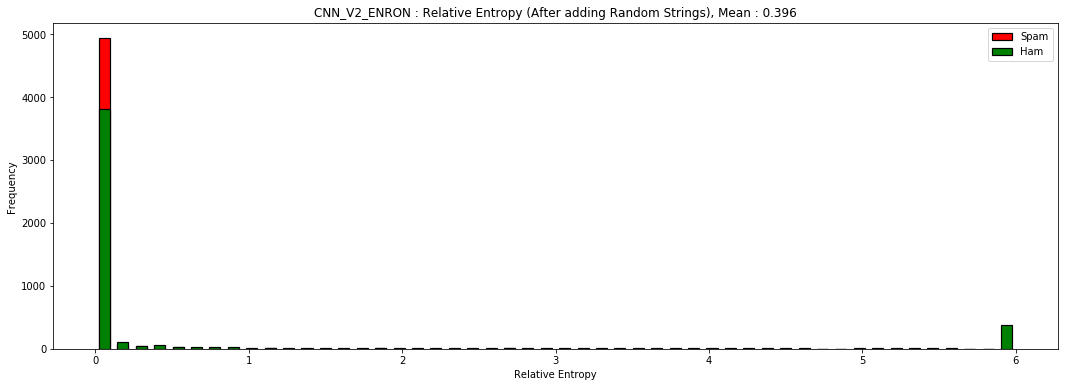

In [67]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V2_ENRON
********************************************************************************
Log Loss :  3.2870361623996804
ROC AUC :  0.961305107668865
Accuracy :  0.9048324933293804
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89      4918
         1.0       0.86      0.98      0.91      5201

   micro avg       0.90      0.90      0.90     10119
   macro avg       0.91      0.90      0.90     10119
weighted avg       0.91      0.90      0.90     10119



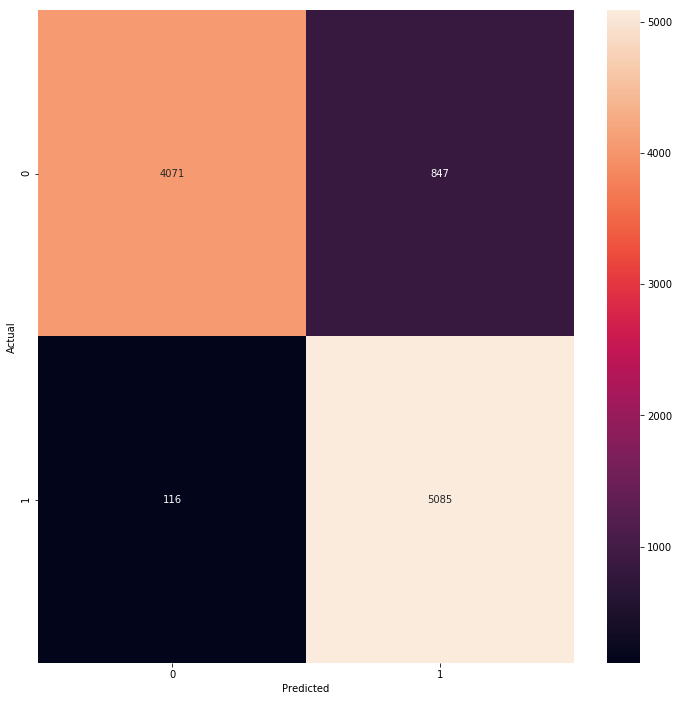

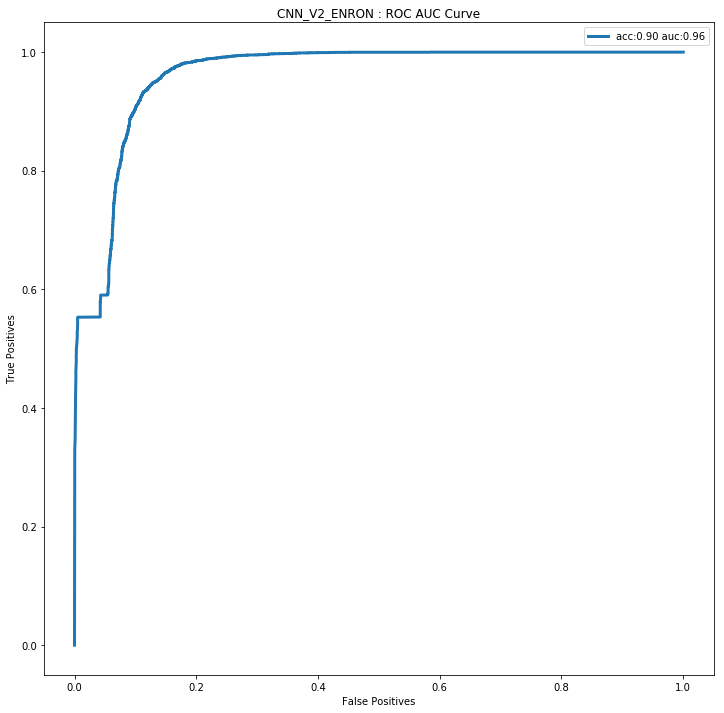

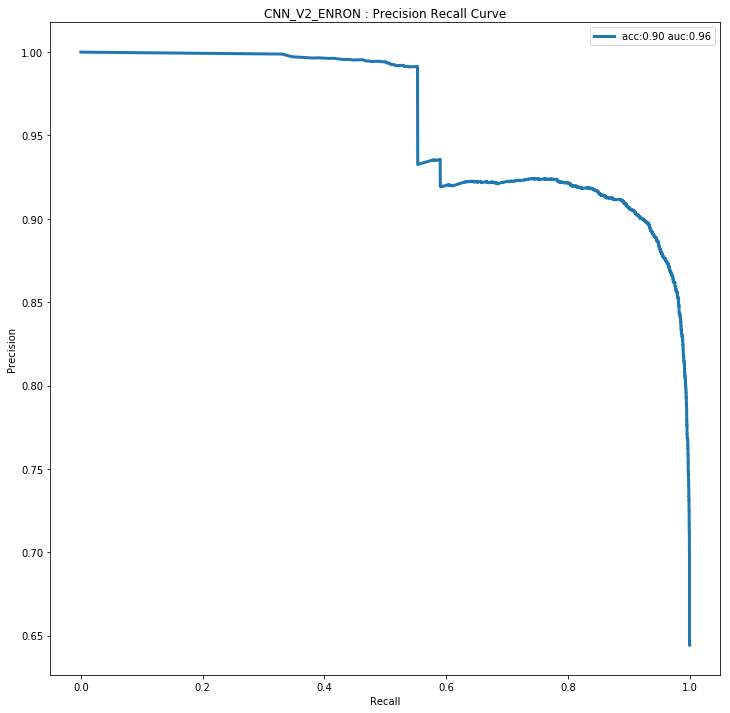

In [68]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [69]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V2_ENRON
********************************************************************************
Mean Shannon Entropy :  0.5765122
Mean Relative Entropy :  0.8055949539315962
Head 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
5201    0.577     1.334     0.0       1       0.263       0.737
5202    0.577     1.334     0.0       1       0.263       0.737
5203    0.577     1.334     0.0       1       0.263       0.737
5204    0.577     1.334     0.0       1       0.263       0.737
5205    0.577     1.334     0.0       1       0.263       0.737
Tail 5 : 
       Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
10114    0.577     1.334     0.0       1       0.263       0.737
10115    0.577     1.334     0.0       1       0.263       0.737
10116    0.577     1.334     0.0       1       0.263       0.737
10117    0.577     1.334     0.0       1       0.263       0.737
10118    0.577    

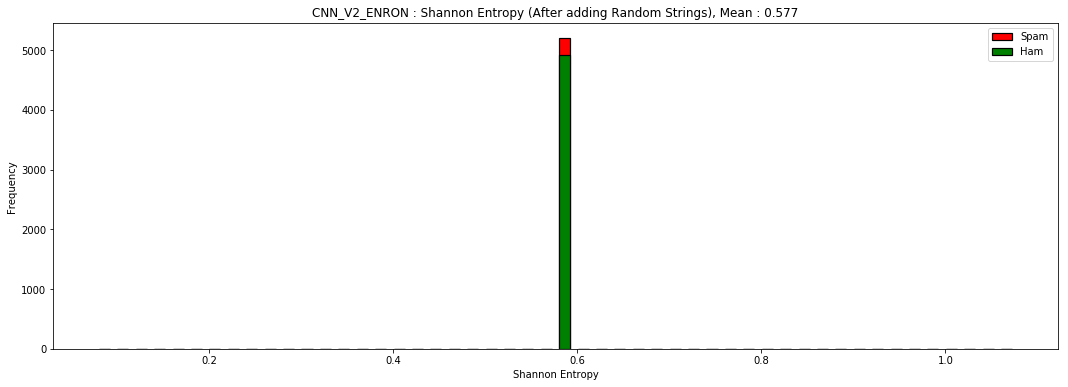

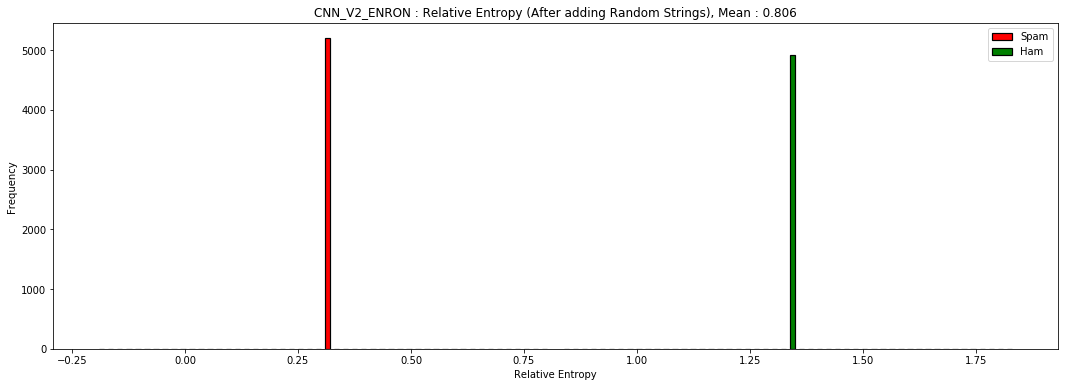

In [70]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V2_ENRON
********************************************************************************
Log Loss :  16.78680054652954
ROC AUC :  0.5
Accuracy :  0.5139835952169187
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4918
         1.0       0.51      1.00      0.68      5201

   micro avg       0.51      0.51      0.51     10119
   macro avg       0.26      0.50      0.34     10119
weighted avg       0.26      0.51      0.35     10119



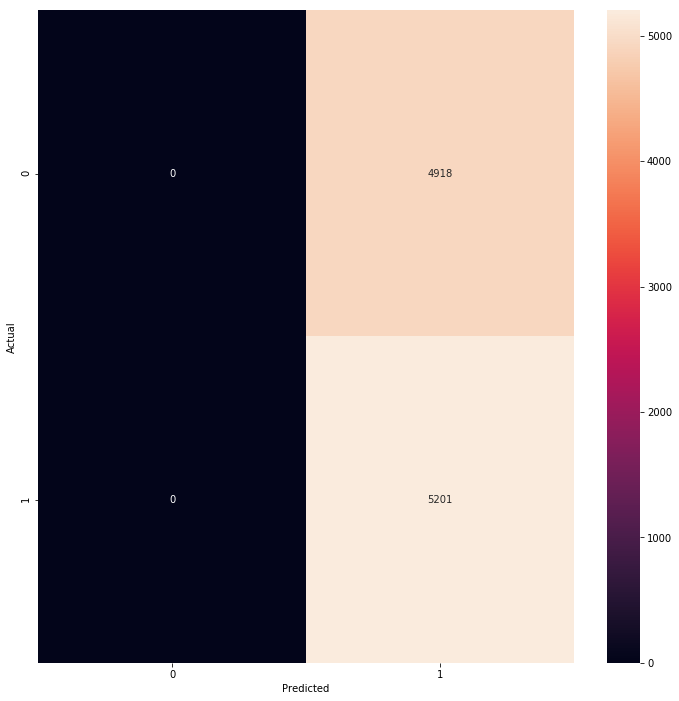

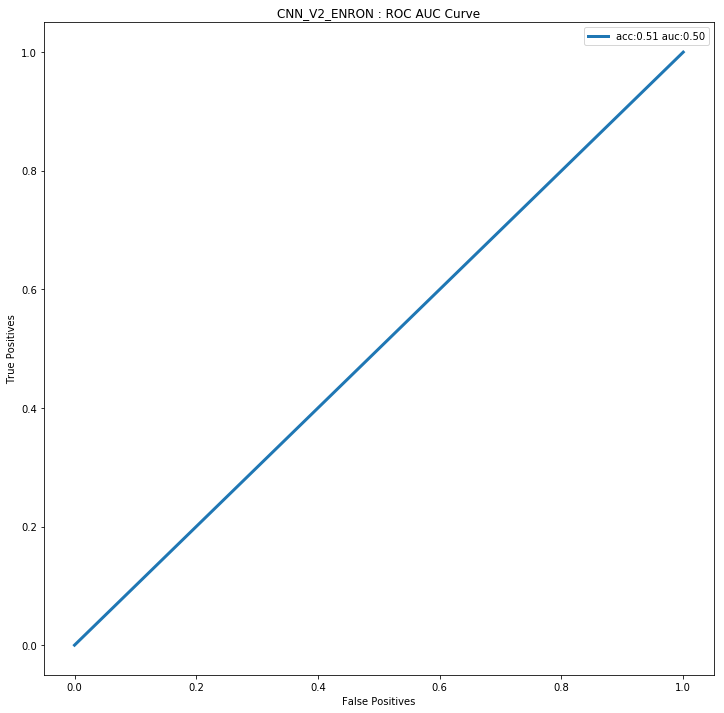

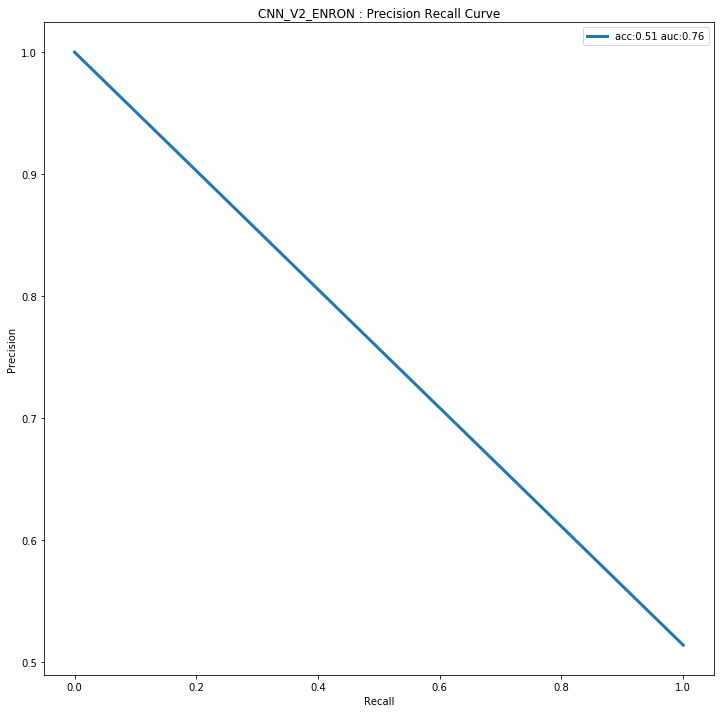

In [71]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)